In [3]:
import os
import sys
import numpy as np
import matplotlib
import datetime
matplotlib.rcParams.update({'font.size': 16})
from trends_and_climatology_functions import get_monthly_observations, plot_monthly_boxplots,  plot_monthly_barplots, plot_double_hist_map, create_region_path, plot_hist_map, get_dict_list_for_labels, extract_result_dict, extract_n_obs_per_day_xarray, extract_result_dict_same_grid, extract_result_dict_xarray, calculate_daily_coverage_for_months, mk_test_for_months, theil_sen_multi_season, extract_merra_dict_list, load_dict_list, get_closest_indices
import matplotlib.path as mpath
import matplotlib.patches as mpatches
np.random.seed(42)
import os
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('bmh')

import numpy as np
import matplotlib
from pyproj import Proj, transform
import xarray as xr
import cartopy.crs as ccrs
#import cKDTree


In [4]:
bands=[31]
data_folder = "../../data/" # Original data folder relative to this script
years = [yr for yr in range(2000, 2026)]
projection = ccrs.Stereographic(central_latitude=90)

#CAOnet
CAOnet_CAO_mask = xr.open_dataarray(data_folder + f"CAOnet_cao_mask_{years[0]}-{years[-1]}_final.nc")

M_threshold=0
T_pressure=850
CAO_mask_M0 = xr.open_dataarray(data_folder + f"merra_cao_mask_Tp{T_pressure}_Mthr{M_threshold}_{years[0]}-{years[-1]}_final.nc")

M_threshold=3.75
CAO_mask_M3_75 = xr.open_dataarray(data_folder + f"merra_cao_mask_Tp{T_pressure}_Mthr{M_threshold}_{years[0]}-{years[-1]}_final.nc")

x_grid = CAOnet_CAO_mask.lon.values
y_grid = CAOnet_CAO_mask.lat.values

In [4]:
obs_mask = (~CAOnet_CAO_mask.isnull()).mean(axis=0)*100#.plot(vmax=1)

x_grid_obs = np.where(obs_mask.values>=90, x_grid, np.nan)
y_grid_obs = np.where(obs_mask.values>=90, y_grid, np.nan)

x_grid_obs_wo = np.where(obs_mask.values>0, x_grid, np.nan)
y_grid_obs_wo = np.where(obs_mask.values>0, y_grid, np.nan)

sw = (x_grid_obs_wo>=-45) & (x_grid_obs_wo<-20) & (y_grid_obs_wo < 70) & (y_grid_obs_wo > 55)
region_sw = np.where(sw & np.isfinite(x_grid_obs))

se = (x_grid_obs_wo>=-20) & (y_grid_obs_wo < 65)  & (y_grid_obs_wo > 55)  & ~((x_grid_obs_wo>15) & (y_grid_obs_wo < 65))
region_se = np.where(se  & np.isfinite(x_grid_obs))

mid = ((x_grid_obs_wo >= -25) & (x_grid_obs_wo < -25) & (y_grid_obs_wo > 70) & (y_grid_obs_wo < 82)) |  ((x_grid_obs_wo >= -25) & (x_grid_obs_wo<25) & (y_grid_obs_wo >= 65) & (y_grid_obs_wo < 82)) & ~((y_grid_obs_wo <68) & (x_grid_obs_wo >20))
region_mid = np.where(mid  & np.isfinite(x_grid_obs))

bar = (x_grid_obs_wo>=25) & (y_grid_obs_wo >= 68) & (y_grid_obs_wo < 82) & (x_grid_obs_wo < 60)
region_bar = np.where(bar  & np.isfinite(x_grid_obs))

south = (x_grid_obs_wo>=-45) & (x_grid_obs_wo<-20) & (y_grid_obs_wo < 65) & (y_grid_obs_wo > 55) | se
region_south = np.where(south  & np.isfinite(x_grid_obs))

all_ = sw | se | mid | bar 
north = mid | bar 
region_north = np.where(north & np.isfinite(x_grid_obs))
region_all = np.where(all_ & np.isfinite(x_grid_obs))
region_all_wo_thr = np.where(all_ & np.isfinite(x_grid_obs_wo))


/uio/kant/geo-geofag-u1/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/uio/kant/geo-geofag-u1/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


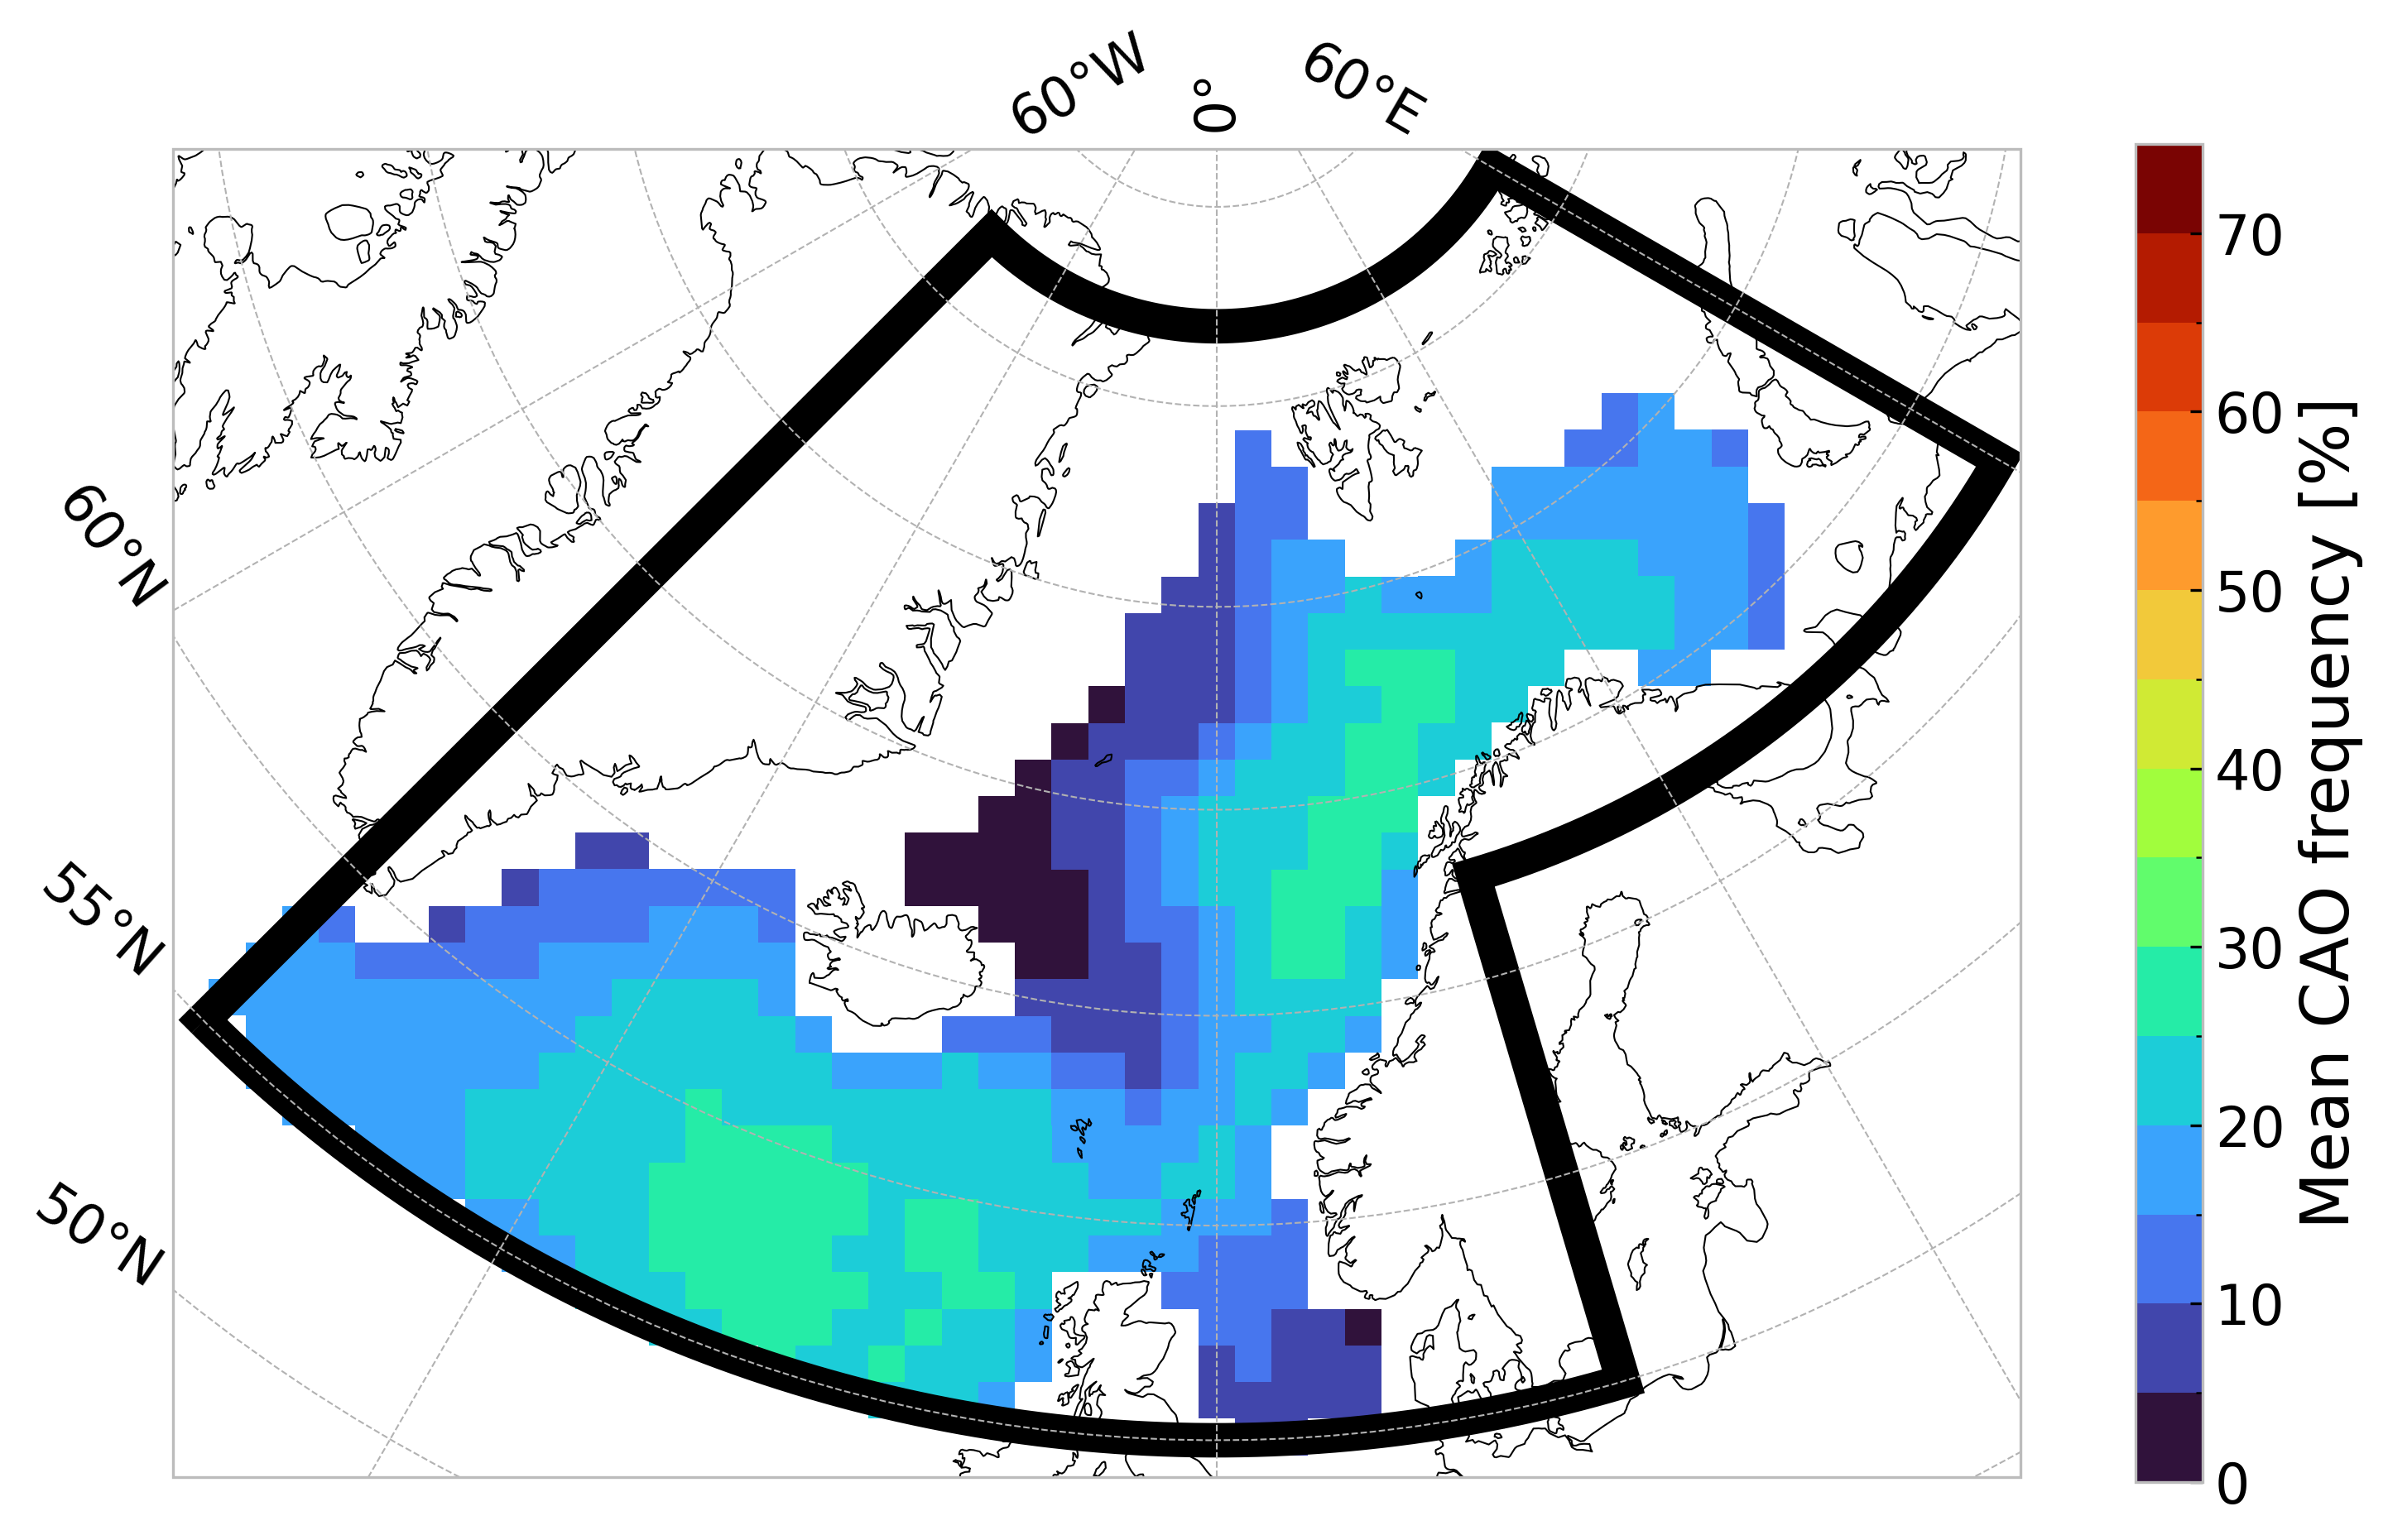

In [5]:
months = [11, 12, 1, 2, 3, 4]
title="Percentage of time with predicted CAO"
extent = [-45, 33, 54, 85]
cmap="turbo"
lon_min, lon_max = -35, 45
lat_min, lat_max = 60, 82
levels = np.arange(0, 80, 5)

month_mask = CAOnet_CAO_mask['time.month'].isin(months)
filtered_data = CAOnet_CAO_mask.where(month_mask, drop=True)
c_CAOnet = filtered_data.sum(dim='time')
d = np.isfinite(filtered_data).sum(dim="time")

month_mask = CAO_mask_M0['time.month'].isin(months)
filtered_data = CAO_mask_M0.where(month_mask, drop=True)
c_merra0 = filtered_data.sum(dim='time')

month_mask = CAO_mask_M3_75['time.month'].isin(months)
filtered_data = CAO_mask_M3_75.where(month_mask, drop=True)
c_merra_best = filtered_data.sum(dim='time')


vertex_coords = [
                [-45, 55],  # Bottom left corner
                [16.5, 55],  # Bottom right corner before the turn upward
                [16.5, 67.5],  # Top right corner after the turn upward
                [60, 67.5],  # Top right corner after the turn rightward
                [60, 82],  # Top right corner
                [-45, 82],  # Top left corner
                [-45.05, 55]  # Top left corner
                ]

fig, ax = plot_hist_map(x_grid,
                        y_grid,
                        c_CAOnet,
                        d,
                        projection,
                        title="",
                        extent=extent,
                        levels=levels,
                        cmap="turbo",
                        vertex_coords=vertex_coords,
                        lon_min=-45,
                        lon_max = 60,
                        lat_min=55,
                        lat_max = 82,
                        plot_type="pcolormesh")
ax.set_facecolor("white")

/uio/kant/geo-geofag-u1/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/uio/kant/geo-geofag-u1/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/uio/kant/geo-geofag-u1/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/uio/kant/geo-geofag-u1/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Pleas

CHANGE


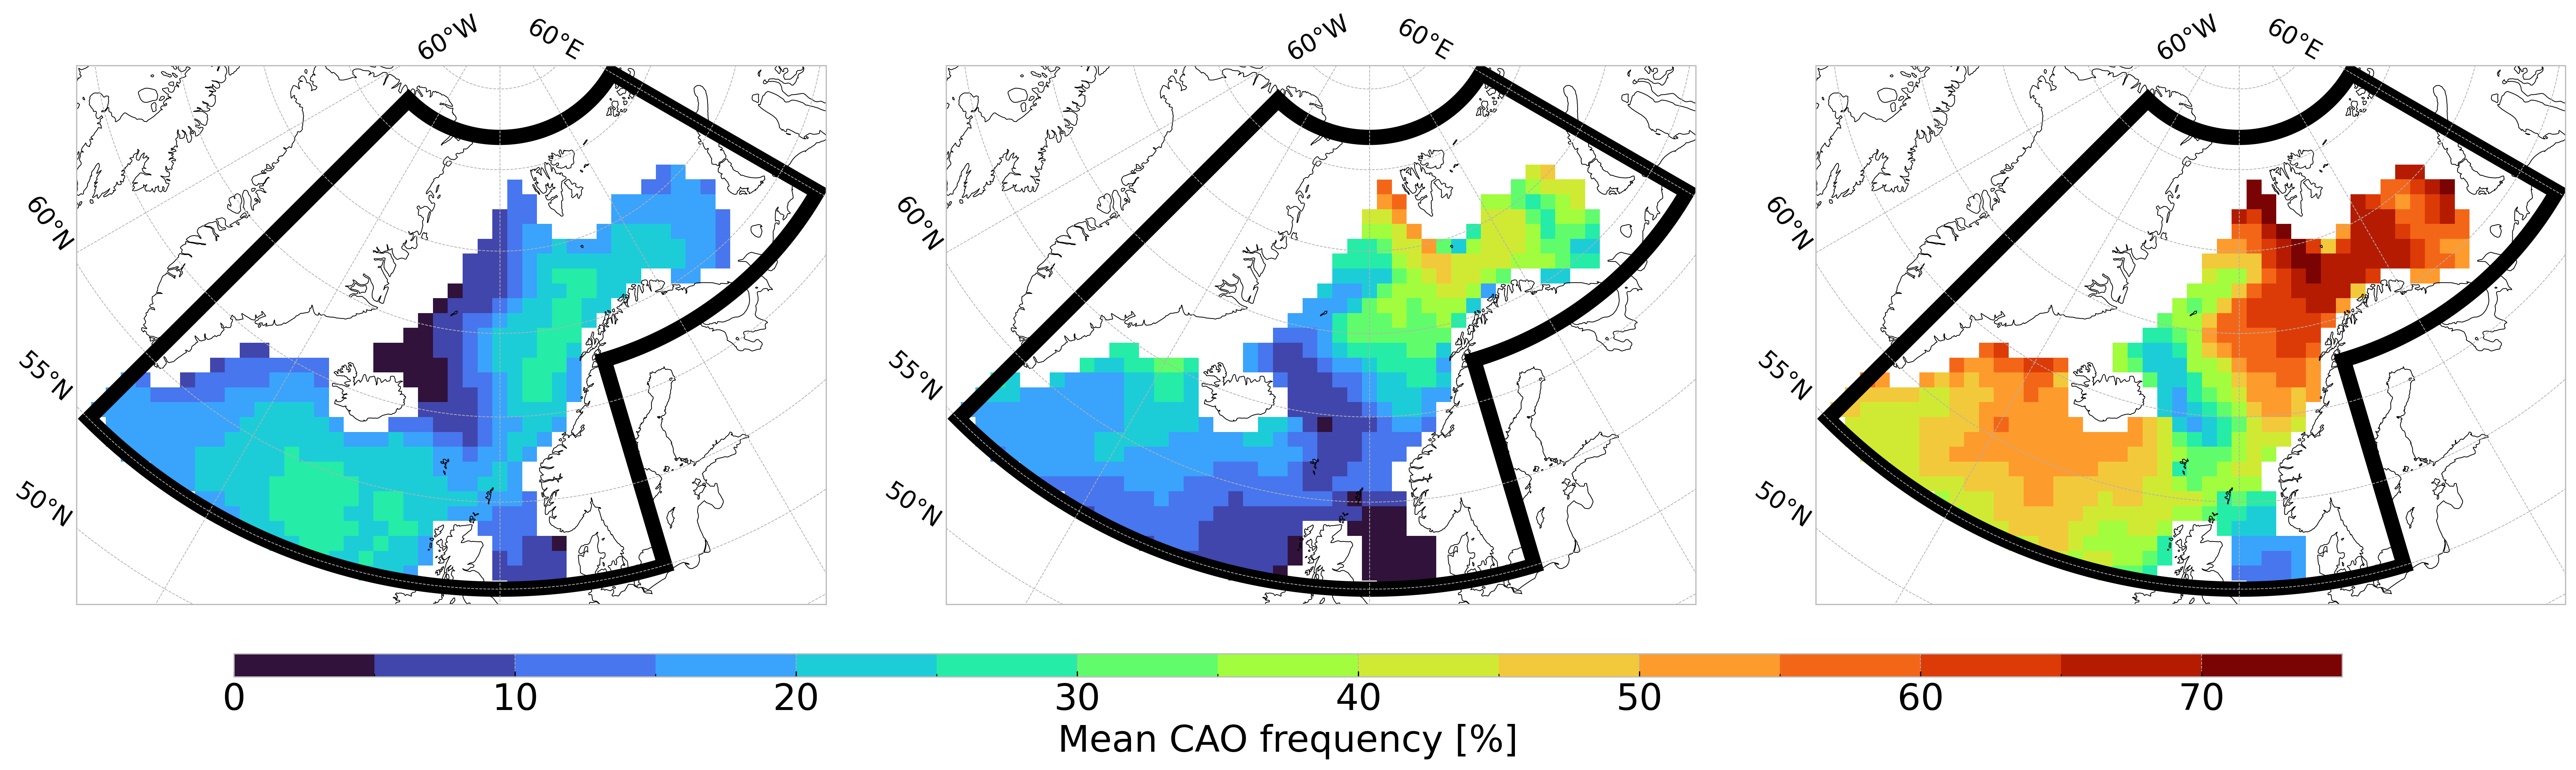

In [6]:

fig, axs = plot_double_hist_map(x_grid,
                        y_grid,
                        [c_CAOnet, c_merra_best, c_merra0],
                        d,
                        projection,
                        extent=extent,
                        levels=levels,
                        cmap="turbo",
                        vertex_coords=vertex_coords,
                        lon_min=-45,
                        lon_max = 60,
                        lat_min=55,
                        lat_max = 82,
                        plot_type="pcolormesh",
                        colorbar_fontsize=24)


axs[0].set_facecolor("white")
axs[1].set_facecolor("white")
axs[2].set_facecolor("white")


In [7]:
from statsmodels.tsa.stattools import acf
months = [9, 10, 11, 12, 1, 2, 3, 4, 5] #, 10, 11, 12, 1, 2, 3, 4, 5]
months_str = [str(t).zfill(2) for t in months]

array_list_all, arr_all = calculate_daily_coverage_for_months(CAOnet_CAO_mask, years, months, region_all)
slopes_all, intercepts_all, p_values_all, slopes_5_all, slopes_95_all = mk_test_for_months(array_list_all, months)
array_list_south, arr_south = calculate_daily_coverage_for_months(CAOnet_CAO_mask, years, months, region_south)
slopes_south, intercepts_south, p_values_south, slopes_5_south, slopes_95_south = mk_test_for_months(array_list_south, months)
array_list_north, arr_north = calculate_daily_coverage_for_months(CAOnet_CAO_mask, years, months, region_north)
slopes_north, intercepts_north, p_values_north, slopes_5_north, slopes_95_north = mk_test_for_months(array_list_north, months)


array_list_merra_all, arr_merra_all = calculate_daily_coverage_for_months(CAO_mask_M0, years, months, region_all)
slopes_merra_all, intercepts_merra_all, p_values_merra_all, slopes_5_merra_all, slopes_95_merra_all = mk_test_for_months(array_list_merra_all, months)
array_list_merra_south, arr_merra_south = calculate_daily_coverage_for_months(CAO_mask_M0, years, months, region_south)
slopes_merra_south, intercepts_merra_south, p_values_merra_south, slopes_5_merra_south, slopes_95_merra_south = mk_test_for_months(array_list_merra_south, months)
array_list_merra_north, arr_merra_north = calculate_daily_coverage_for_months(CAO_mask_M0, years, months, region_north)
slopes_merra_north, intercepts_merra_north, p_values_merra_north, slopes_5_merra_north, slopes_95_merra_north = mk_test_for_months(array_list_merra_north, months)


array_list_merra_best_all, arr_merra_best_all = calculate_daily_coverage_for_months(CAO_mask_M3_75, years, months, region_all)
slopes_merra_best_all, intercepts_merra_best_all, p_values_merra_best_all, slopes_5_merra_best_all, slopes_95_merra_best_all = mk_test_for_months(array_list_merra_best_all, months)
array_list_merra_best_south, arr_merra_best_south = calculate_daily_coverage_for_months(CAO_mask_M3_75, years, months, region_south)
slopes_merra_best_south, intercepts_merra_best_south, p_values_merra_best_south, slopes_5_merra_best_south, slopes_95_merra_best_south = mk_test_for_months(array_list_merra_best_south, months)
array_list_merra_best_north, arr_merra_best_north = calculate_daily_coverage_for_months(CAO_mask_M3_75, years, months, region_north)
slopes_merra_best_north, intercepts_merra_best_north, p_values_merra_best_north, slopes_5_merra_best_north, slopes_95_merra_best_north = mk_test_for_months(array_list_merra_best_north, months)

/uio/kant/geo-geofag-u1/fslippe/Shortening_Arctic_CAO_season/code/trends_and_climatology_functions.py:376: RuntimeWarning: Mean of empty slice
  arr[i, j] = np.nanmean(data_month.values[:, region_mask[0], region_mask[1]], axis=1)#data_month.values[:, region_all[0], region_all[1]].mean(axis=0)
/uio/kant/geo-geofag-u1/fslippe/Shortening_Arctic_CAO_season/code/trends_and_climatology_functions.py:376: RuntimeWarning: Mean of empty slice
  arr[i, j] = np.nanmean(data_month.values[:, region_mask[0], region_mask[1]], axis=1)#data_month.values[:, region_all[0], region_all[1]].mean(axis=0)
/uio/kant/geo-geofag-u1/fslippe/Shortening_Arctic_CAO_season/code/trends_and_climatology_functions.py:376: RuntimeWarning: Mean of empty slice
  arr[i, j] = np.nanmean(data_month.values[:, region_mask[0], region_mask[1]], axis=1)#data_month.values[:, region_all[0], region_all[1]].mean(axis=0)
/uio/kant/geo-geofag-u1/fslippe/Shortening_Arctic_CAO_season/code/trends_and_climatology_functions.py:376: RuntimeWarn

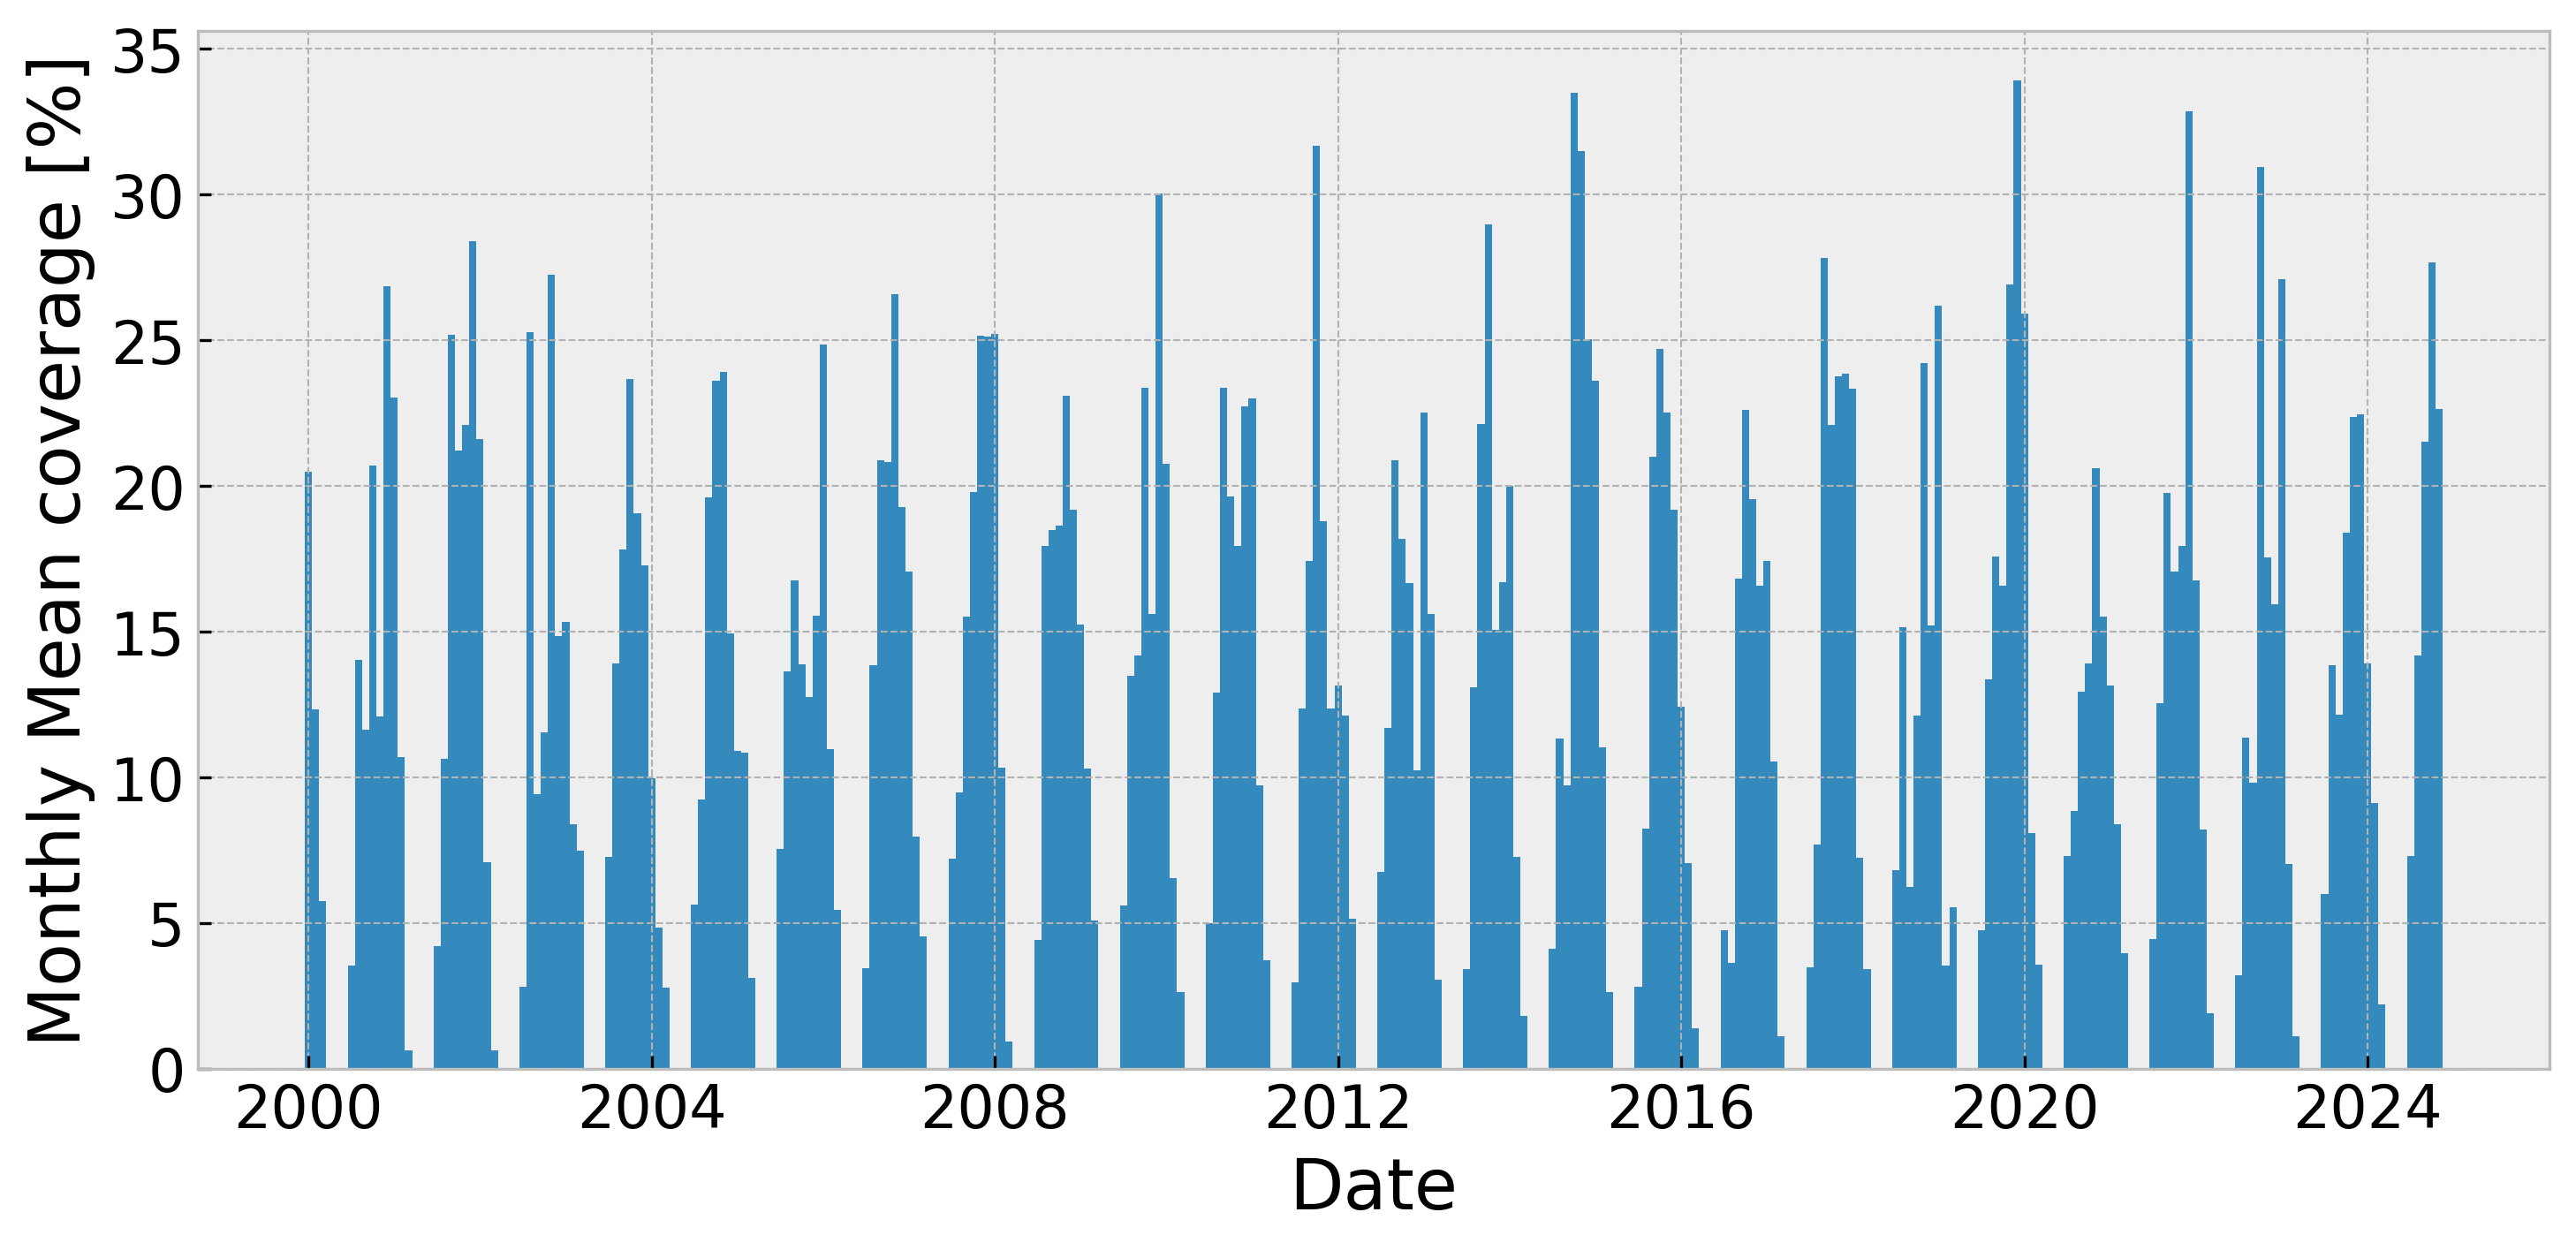

In [8]:
time_as_ym = pd.to_datetime(CAOnet_CAO_mask['time'].values).strftime('%Y%m')
CAOnet_CAO_mask = CAOnet_CAO_mask.assign_coords(time_ym=('time', time_as_ym))

monthly_data = CAOnet_CAO_mask.mean(["x", "y"]).groupby('time_ym')

monthly_means = monthly_data.mean()

unique_dates_raw = [datetime.datetime.strptime(str(t), '%Y%m') for t in time_as_ym]
unique_dates = np.unique(unique_dates_raw)

date_start = min(unique_dates)
date_end = max(unique_dates)
full_date_range = pd.date_range(date_start, date_end, freq='M')

data_dict = {date: monthly_means.sel(time_ym=date.strftime('%Y%m')).values.item()*100 if date.strftime('%Y%m') in monthly_means.time_ym.values else np.nan
             for date in full_date_range}

# Extract dates and values into ordered lists for plotting
ordered_dates = list(data_dict.keys())
ordered_means = list(data_dict.values())

# Plot using indices for x-values
plt.figure(figsize=[10, 5], dpi=300)
plt.bar(np.arange(len(ordered_means)), ordered_means, width=1)

# Formatting the x-axis
selected_indices = np.arange(0, len(ordered_dates), 48)
# Apply xticks only to selected indices
plt.xticks(selected_indices, labels=[ordered_dates[i].strftime('%Y') for i in selected_indices], rotation=0)

plt.xlabel('Date')
plt.ylabel('Monthly Mean coverage [%]')
plt.tight_layout()
plt.show()


ALL
SOUTH


/tmp/ipykernel_3522971/1895254756.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_3522971/1895254756.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


NORTH


/tmp/ipykernel_3522971/1895254756.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


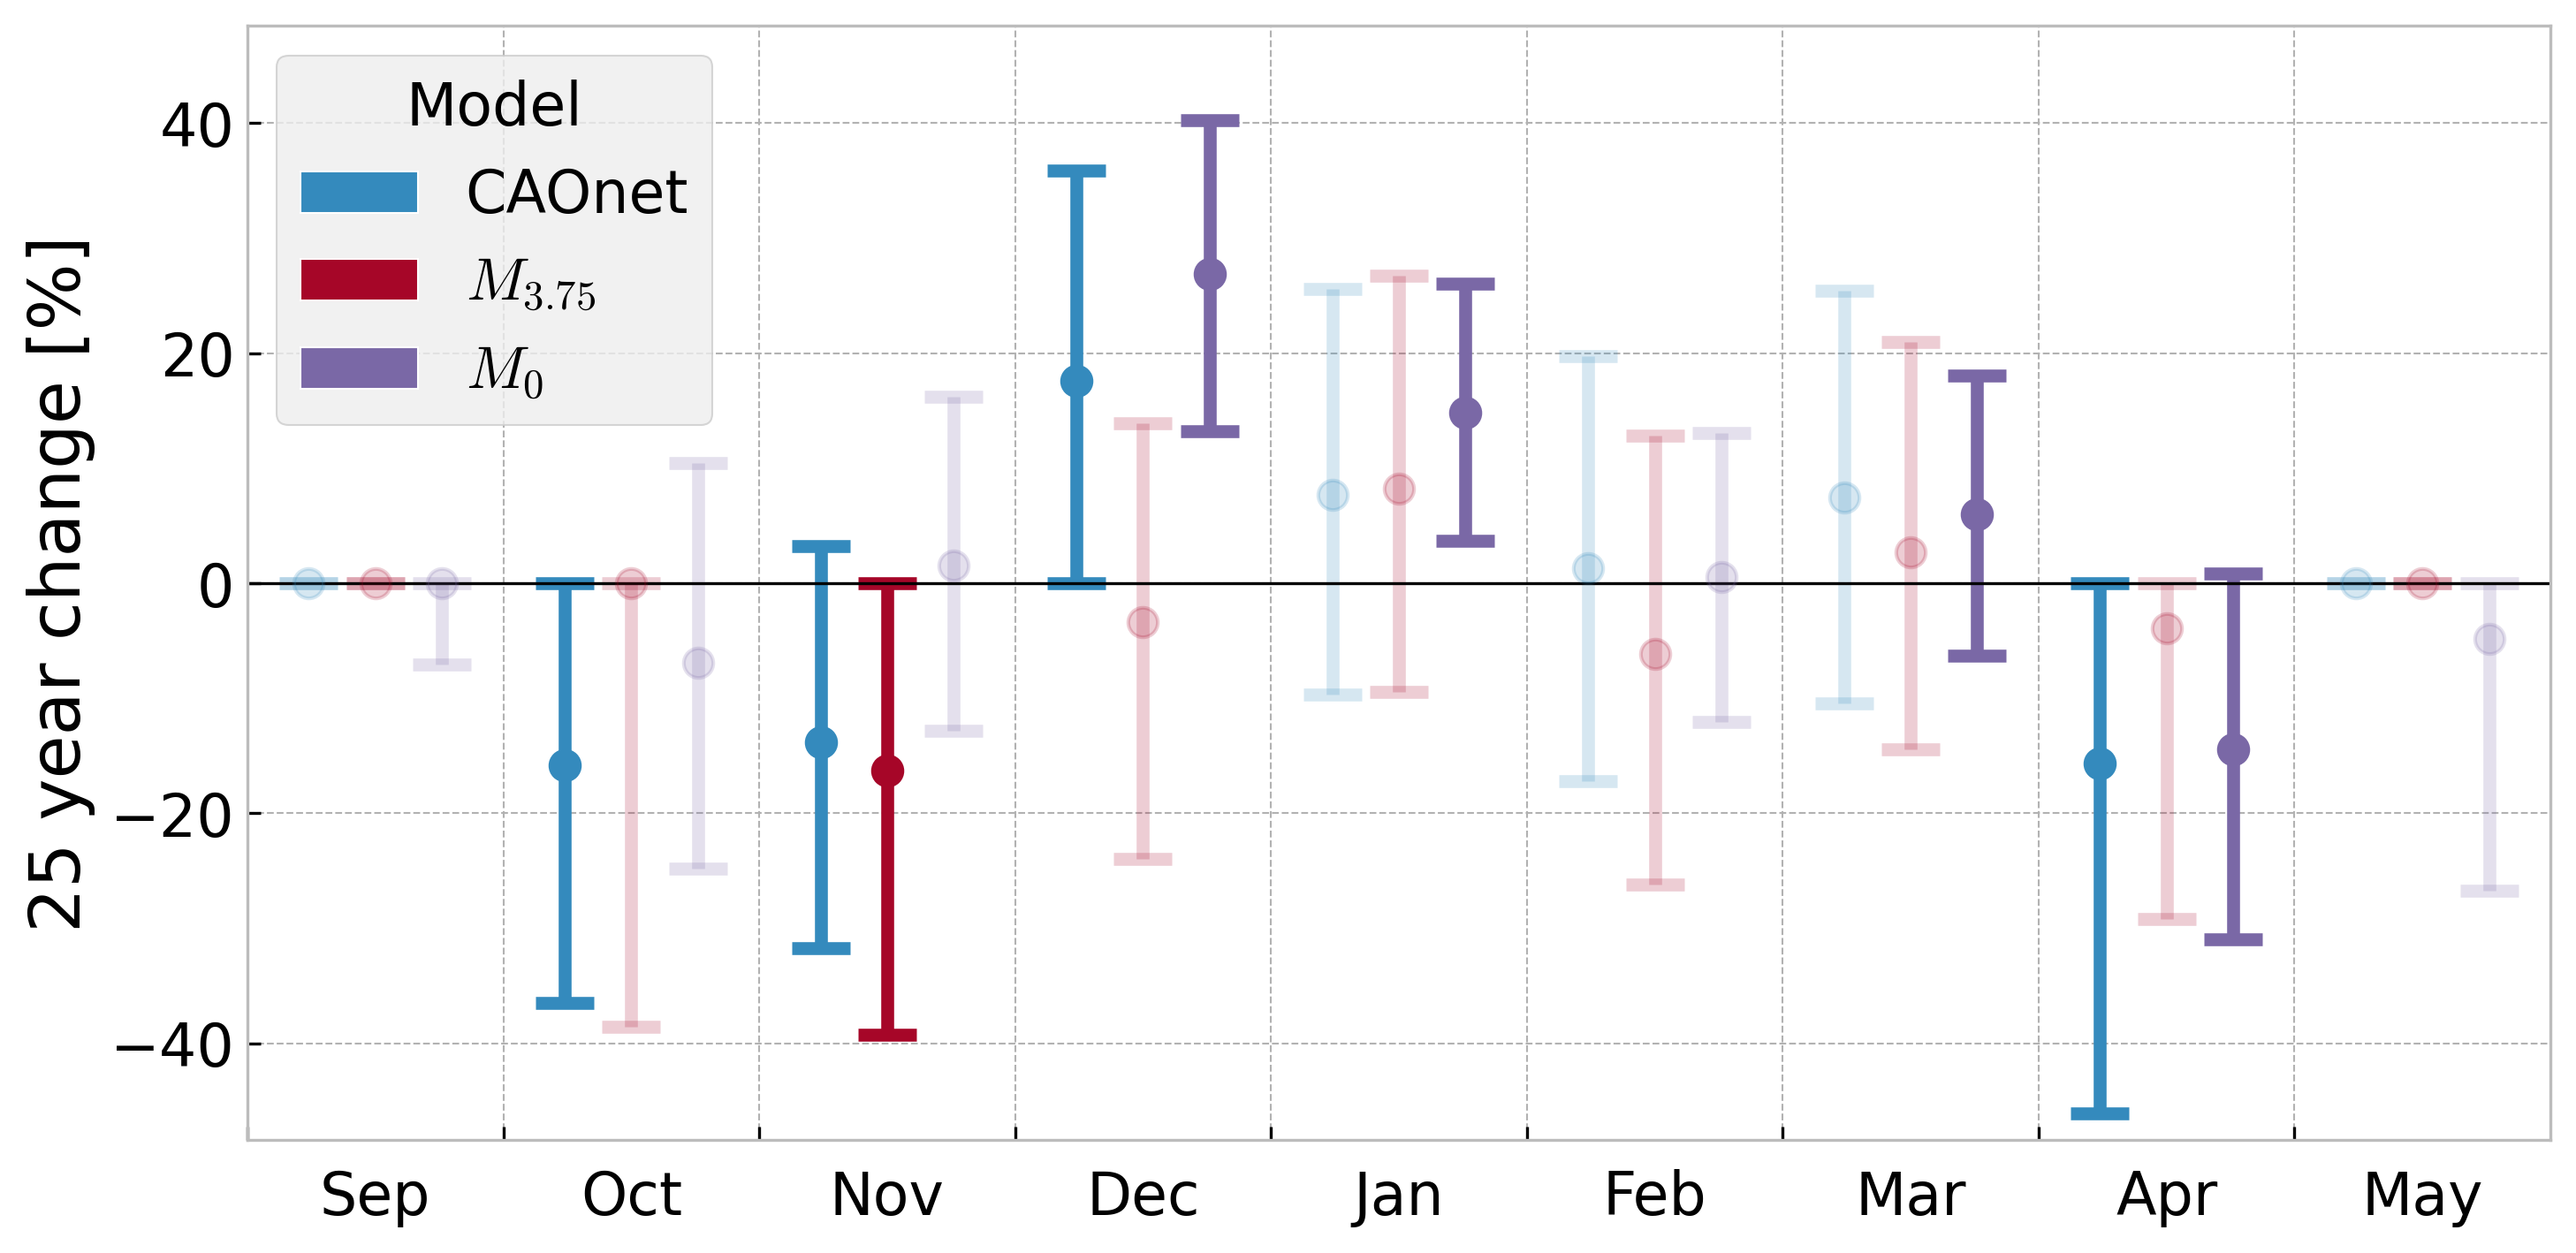

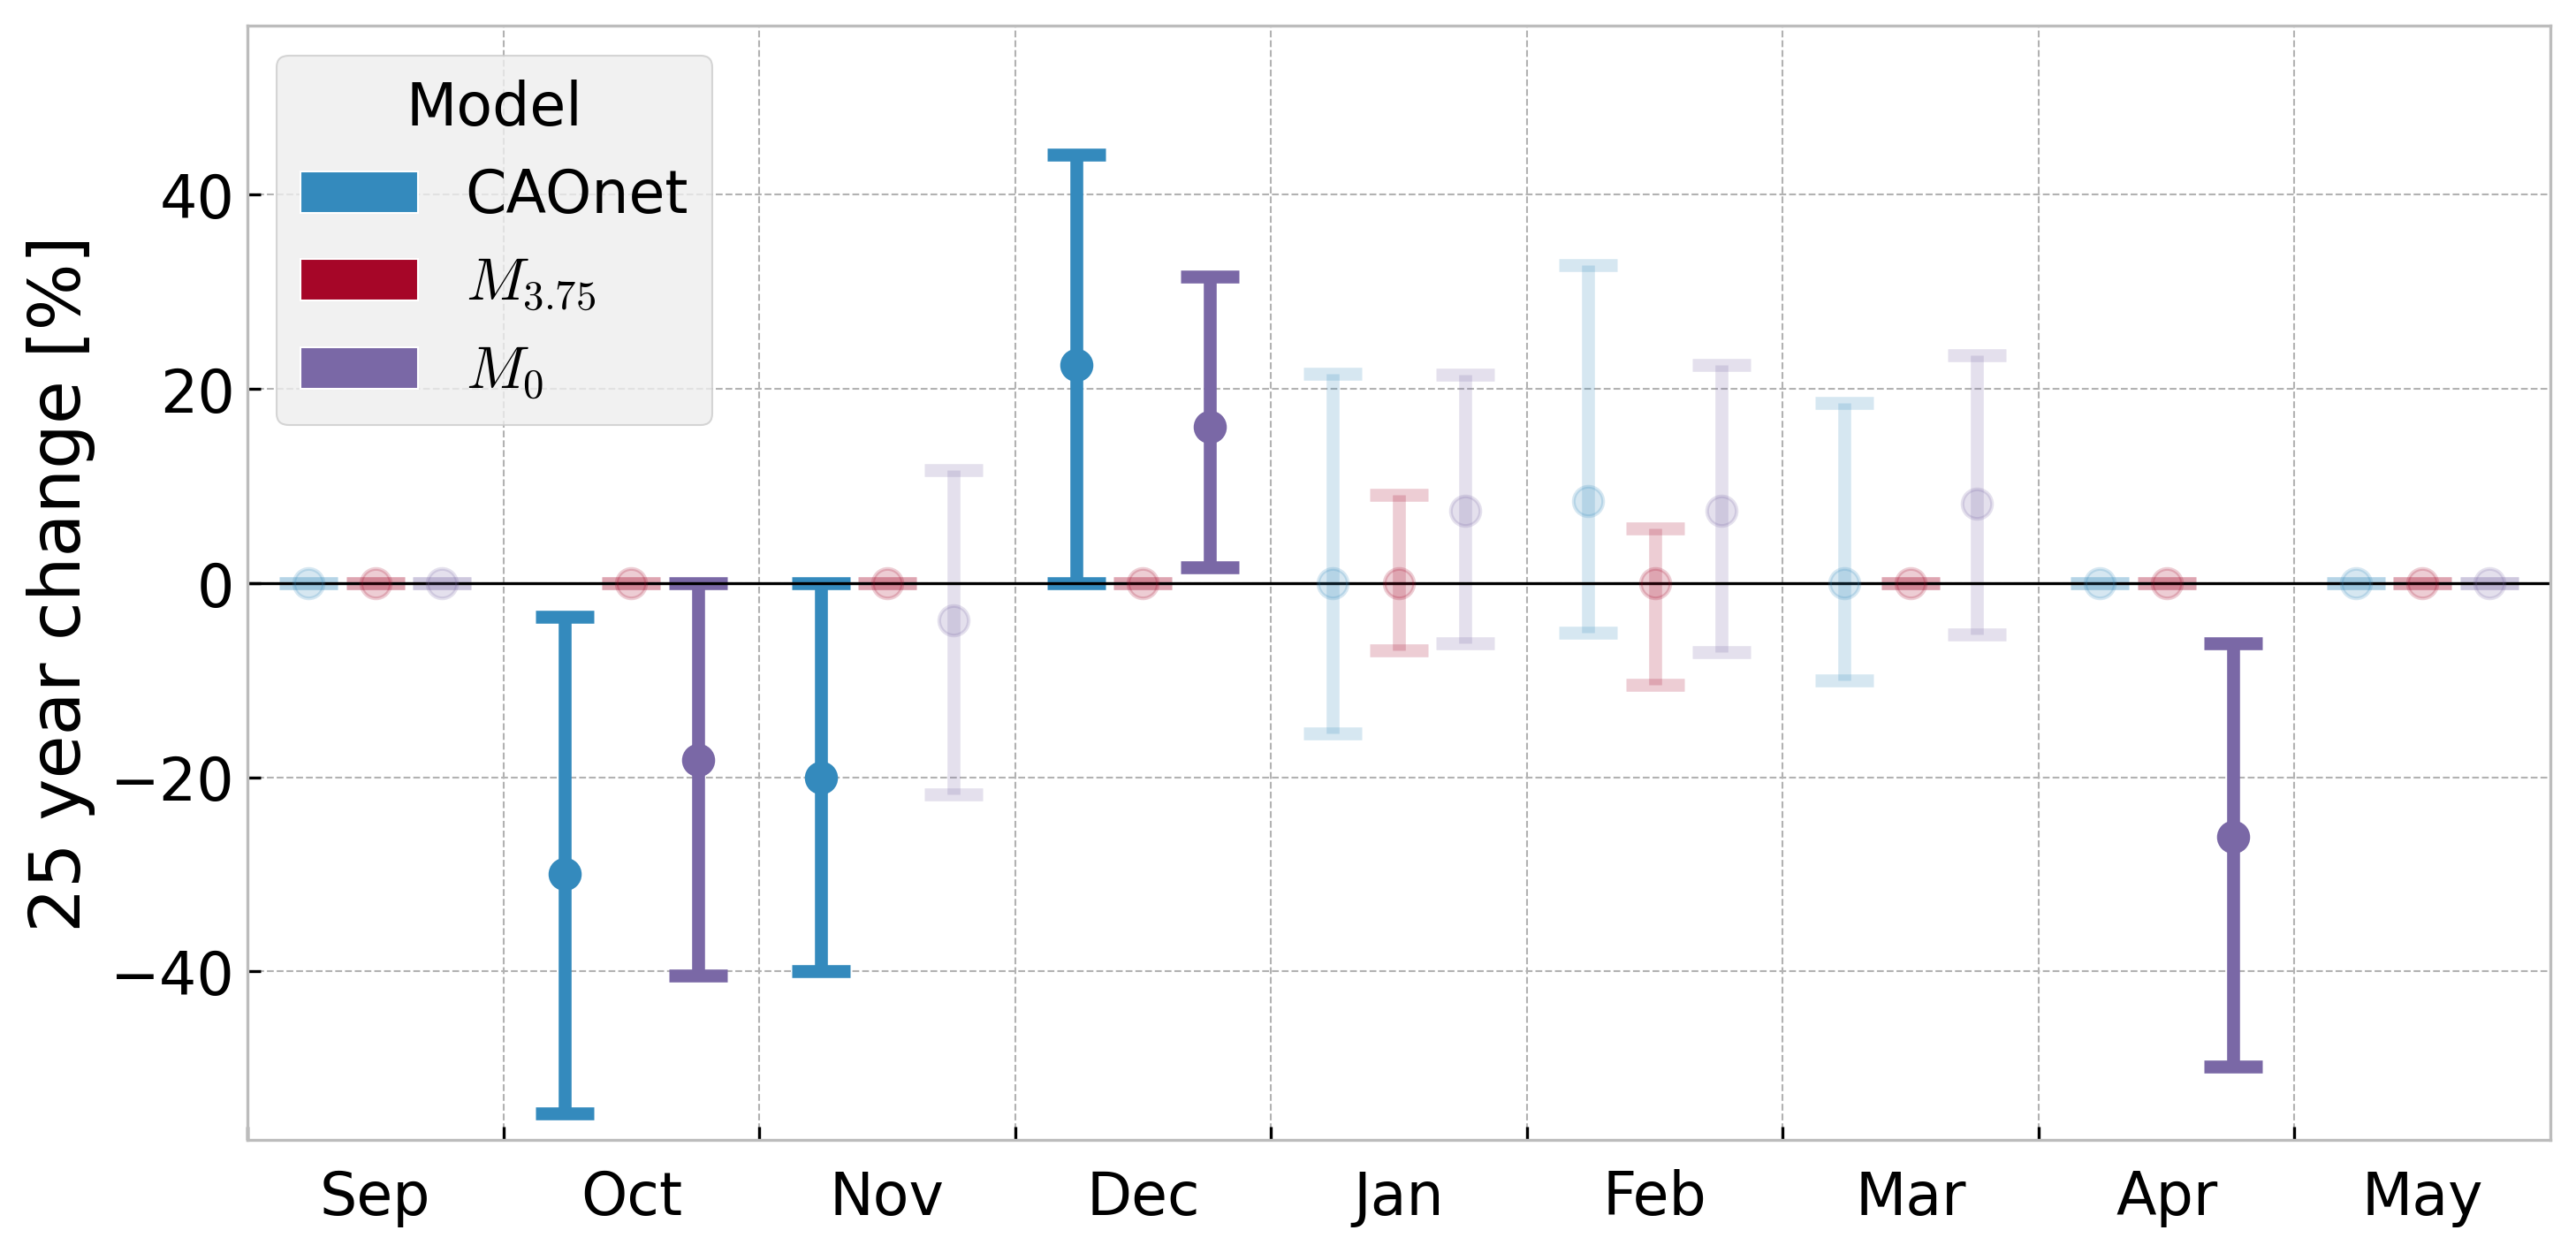

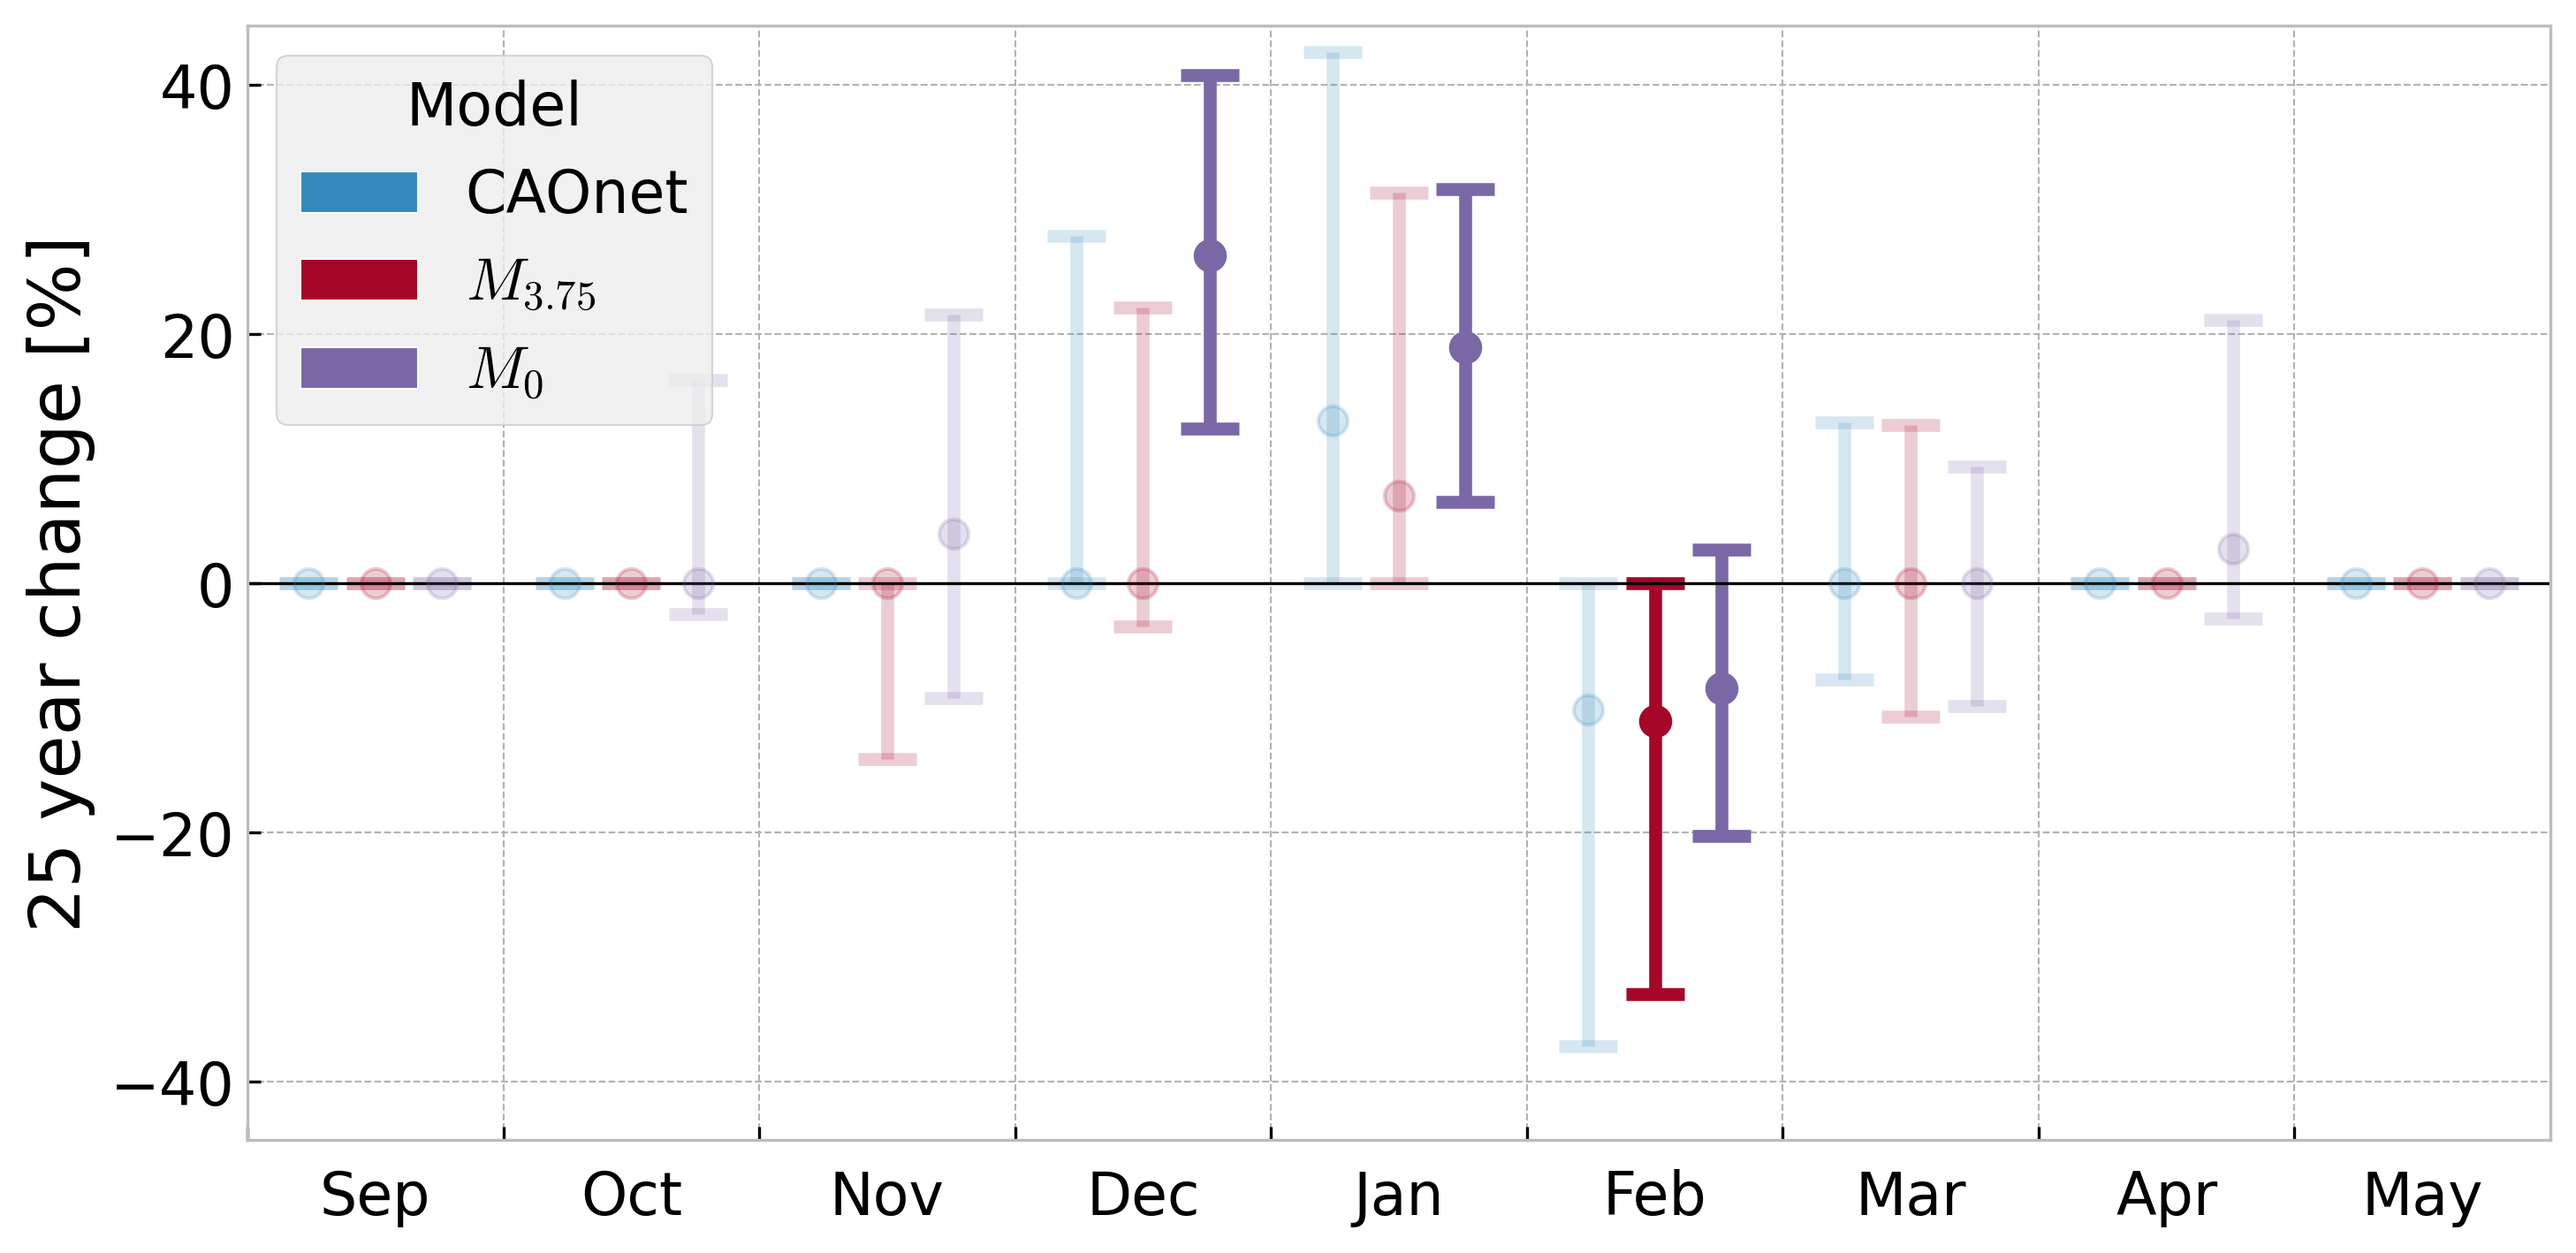

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import calendar

figsize_trends = [10, 5]
month_names = [calendar.month_abbr[int(month)] for month in months_str]

print("ALL")
fig, ax = plot_monthly_boxplots(month_names,
                            [slopes_all, slopes_merra_best_all, slopes_merra_all],
                            [intercepts_all, intercepts_merra_best_all, intercepts_merra_all],
                            [p_values_all, p_values_merra_best_all, p_values_merra_all],
                            [slopes_5_all, slopes_5_merra_best_all, slopes_5_merra_all], 
                            [slopes_95_all, slopes_95_merra_best_all, slopes_95_merra_all], 
                            [array_list_all, array_list_merra_best_all, array_list_merra_all],
                            ["CAOnet", r"$M_{3.75}$", r"$M_0$"], alpha=0.05, figsize=figsize_trends)
fig.show()

print("SOUTH")
fig, ax = plot_monthly_boxplots(month_names,
                            [slopes_south, slopes_merra_best_south, slopes_merra_south],
                            [intercepts_south, intercepts_merra_best_south, intercepts_merra_south],
                            [p_values_south, p_values_merra_best_south, p_values_merra_south],
                            [slopes_5_south, slopes_5_merra_best_south, slopes_5_merra_south], 
                            [slopes_95_south, slopes_95_merra_best_south, slopes_95_merra_south], 
                            [array_list_south, array_list_merra_best_south, array_list_merra_south],
                            ["CAOnet", r"$M_{3.75}$", r"$M_0$"], alpha=0.05, figsize=figsize_trends)
fig.show()


print("NORTH")
fig, ax = plot_monthly_boxplots(month_names,
                            [slopes_north, slopes_merra_best_north, slopes_merra_north],
                            [intercepts_north, intercepts_merra_best_north, intercepts_merra_north],
                            [p_values_north, p_values_merra_best_north, p_values_merra_north],
                            [slopes_5_north, slopes_5_merra_best_north, slopes_5_merra_north], 
                            [slopes_95_north, slopes_95_merra_best_north, slopes_95_merra_north], 
                            [array_list_north, array_list_merra_best_north, array_list_merra_north],
                            ["CAOnet", r"$M_{3.75}$", r"$M_0$"], alpha=0.05, figsize=figsize_trends)
ax.set_yticks([-40, -20, 0, 20, 40])

fig.show() 


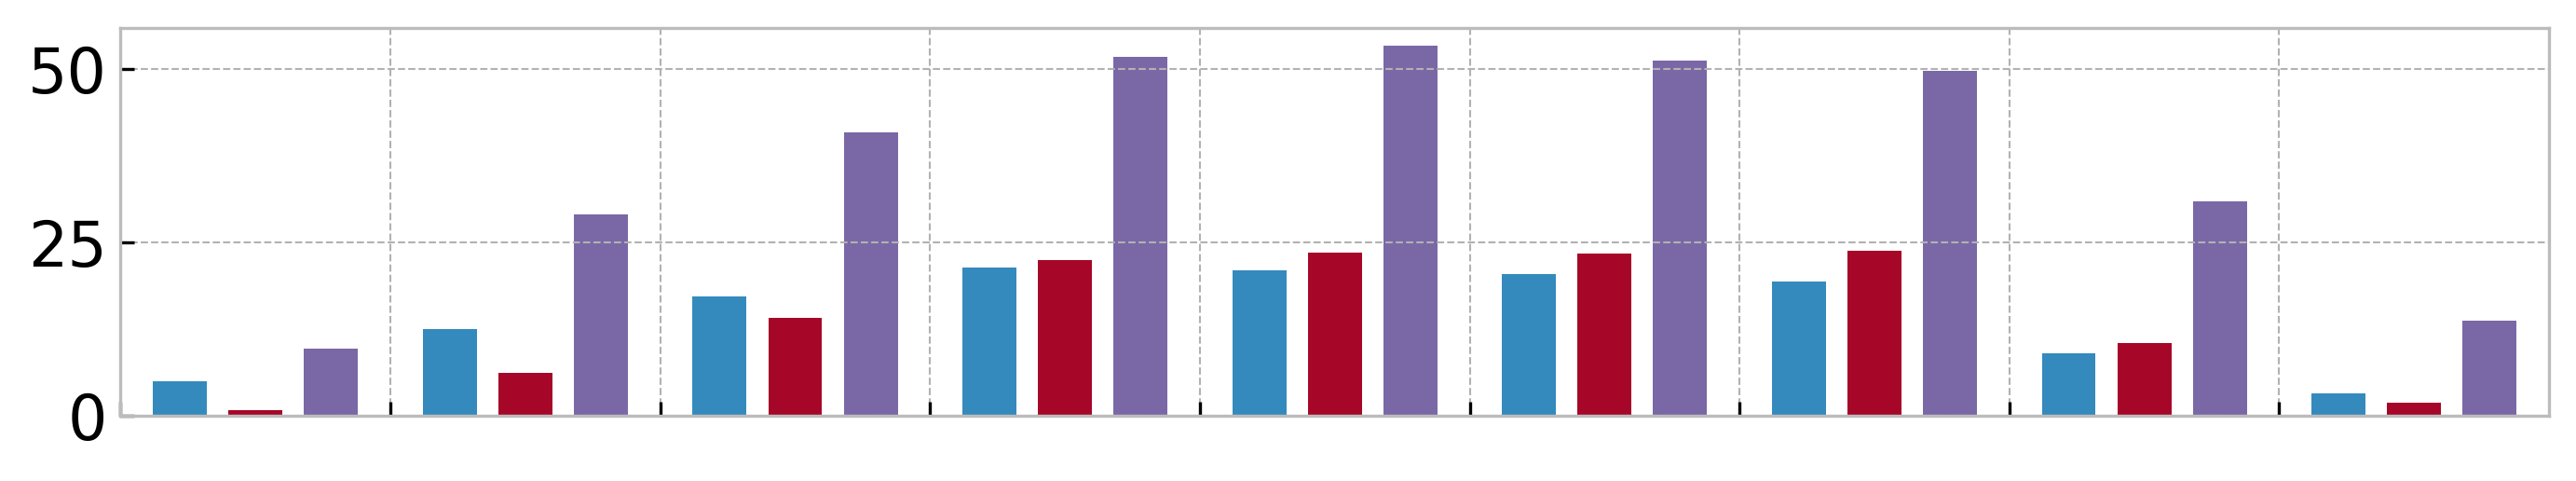

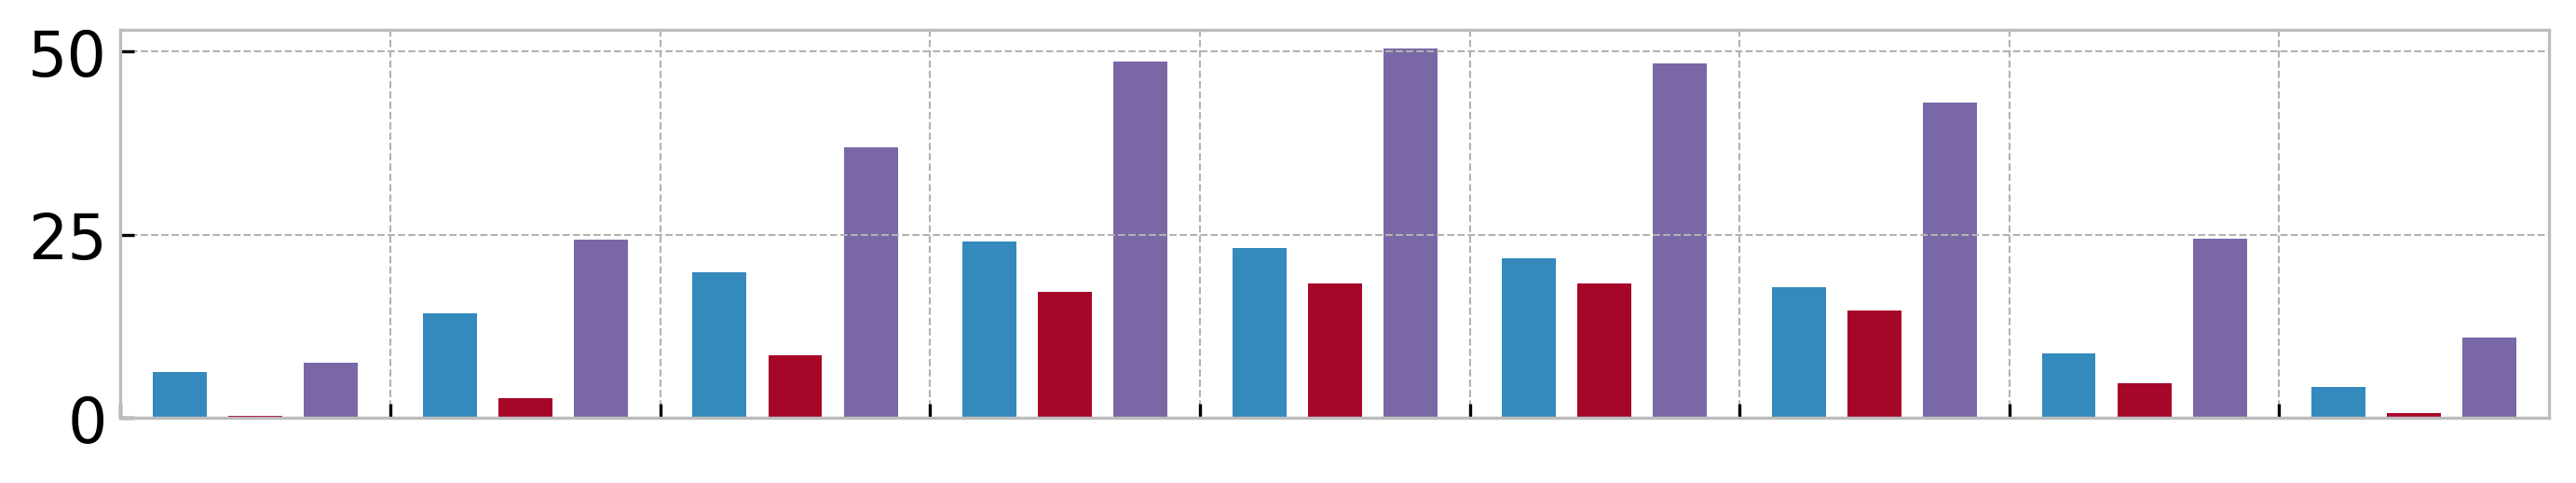

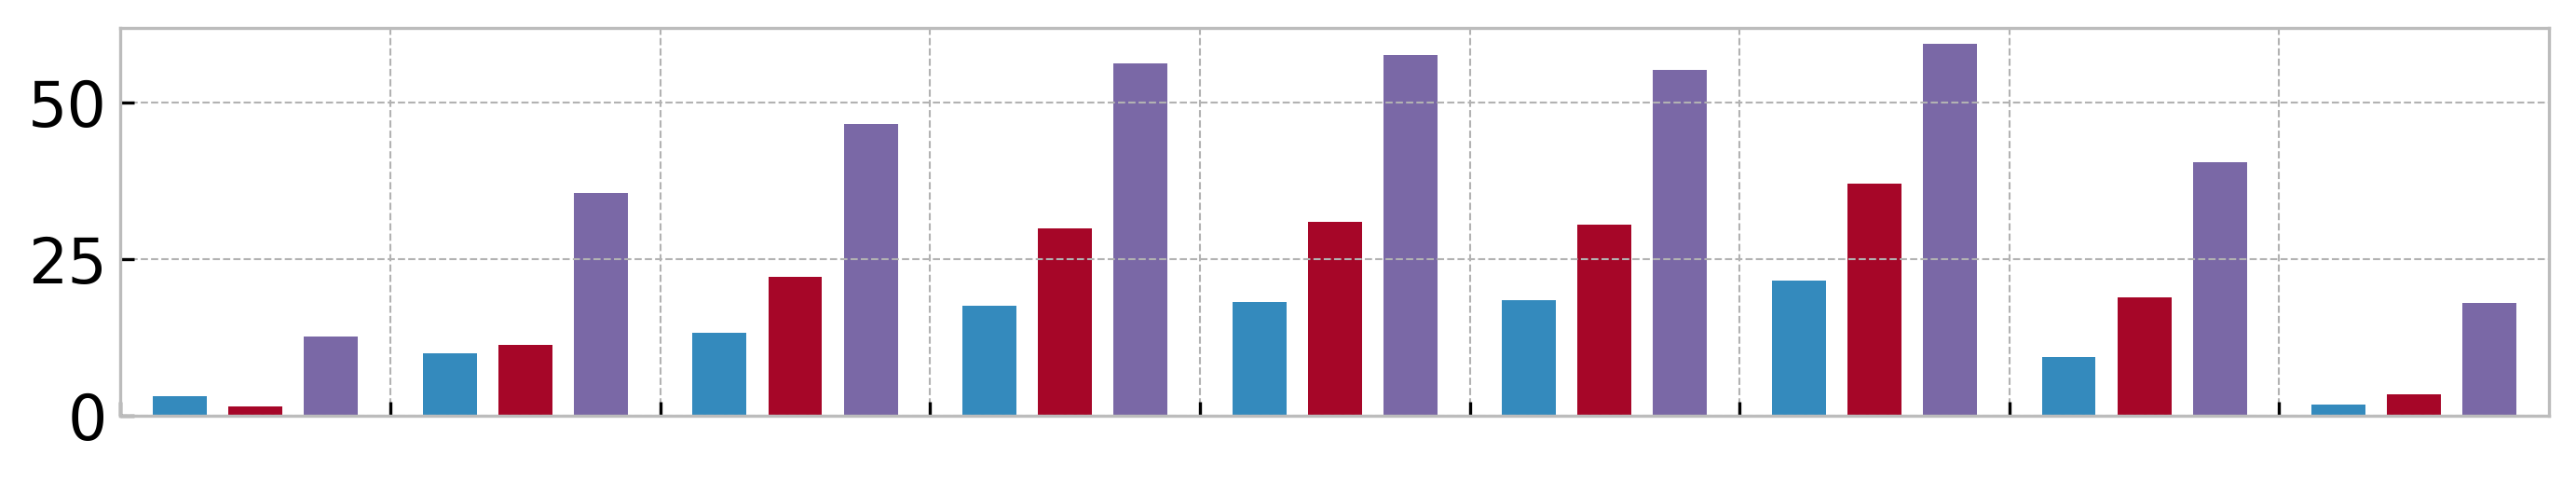

In [10]:
month_names = [calendar.month_abbr[int(month)] for month in months_str]
array_lists = [array_list_all, array_list_merra_best_all, array_list_merra_all]  # Example with three models data
model_names = ["CAOnet", r"$M_{3.75}$", r"$M_0$"]
fig = plot_monthly_barplots(month_names, array_lists, model_names, alpha=0.05, legend=False,  figsize=[figsize_trends[0]-0.5,2])


array_lists = [array_list_south, array_list_merra_best_south, array_list_merra_south]  # Example with three models data
fig = plot_monthly_barplots(month_names, array_lists, model_names, alpha=0.05, legend=False, figsize=[figsize_trends[0]-0.5,2])

array_lists = [array_list_north, array_list_merra_best_north, array_list_merra_north]  # Example with three models data
fig = plot_monthly_barplots(month_names, array_lists, model_names, alpha=0.05, legend=False,  figsize=[figsize_trends[0]-0.5,2])



In [11]:
season_slopes_all, season_intercepts_all, season_low_all, season_high_all, p_values_all = theil_sen_multi_season(arr_all)
season_slopes_merra_best_all, season_intercepts_merra_best_all, season_low_merra_best_all, season_high_merra_best_all, p_values_merra_best_all = theil_sen_multi_season(arr_merra_best_all)
season_slopes_merra0_all, season_intercepts_merra0_all, season_low_merra0_all, season_high_merra0_all, p_values_merra0_all = theil_sen_multi_season(arr_merra_all)

season_slopes_south, season_intercepts_south, season_low_south, season_high_south, p_values_south = theil_sen_multi_season(arr_south)
season_slopes_merra_best_south, season_intercepts_merra_best_south, season_low_merra_best_south, season_high_merra_best_south, p_values_merra_best_south = theil_sen_multi_season(arr_merra_best_south)
season_slopes_merra0_south, season_intercepts_merra0_south, season_low_merra0_south, season_high_merra0_south, p_values_merra0_south = theil_sen_multi_season(arr_merra_south)

season_slopes_north, season_intercepts_north, season_low_north, season_high_north, p_values_north = theil_sen_multi_season(arr_north)
season_slopes_merra_best_north, season_intercepts_merra_best_north, season_low_merra_best_north, season_high_merra_best_north, p_values_merra_best_north = theil_sen_multi_season(arr_merra_best_north)
season_slopes_merra0_north, season_intercepts_merra0_north, season_low_merra0_north, season_high_merra0_north, p_values_merra0_north = theil_sen_multi_season(arr_merra_north)


3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


(-29.0, 29.0)

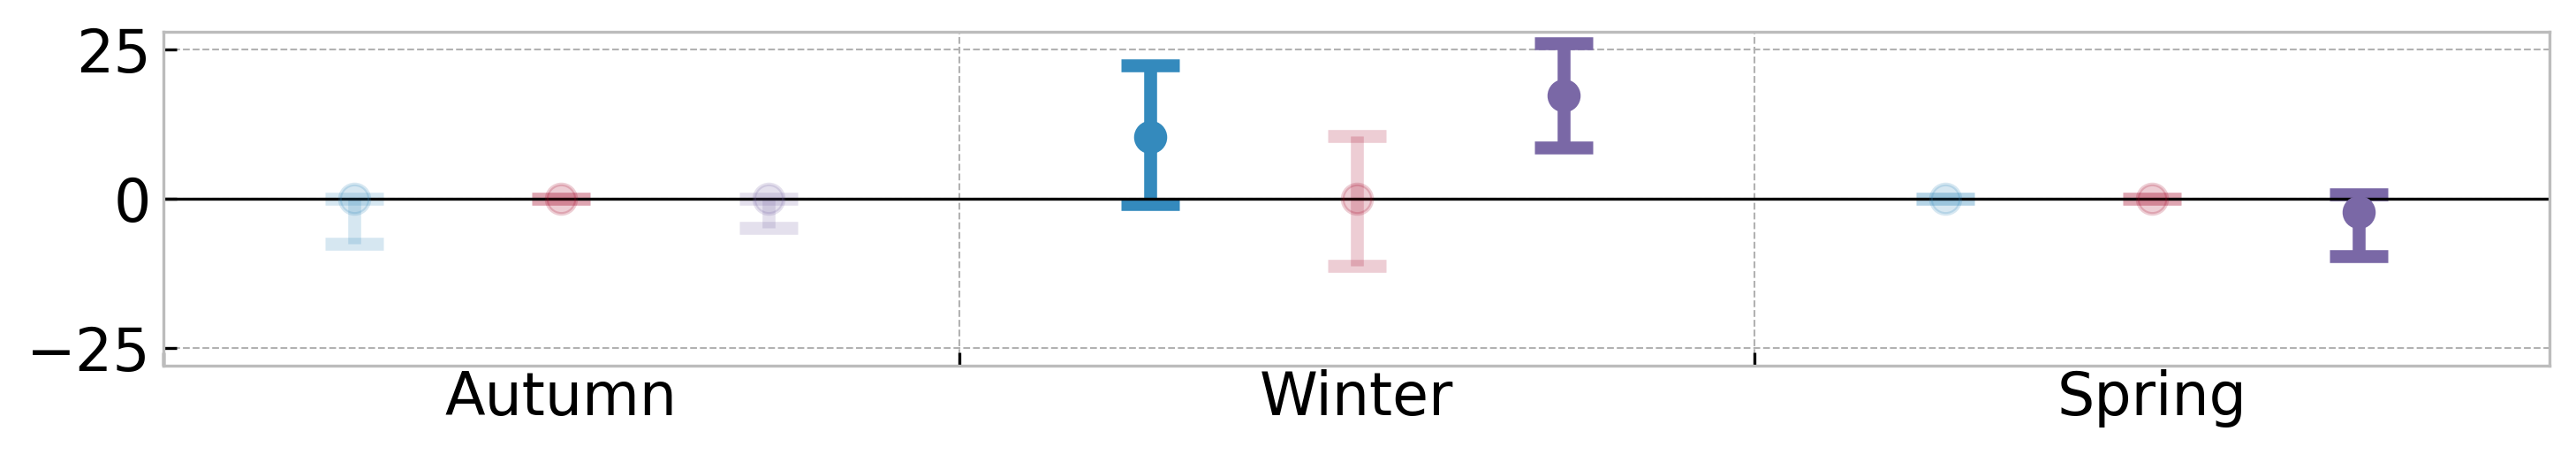

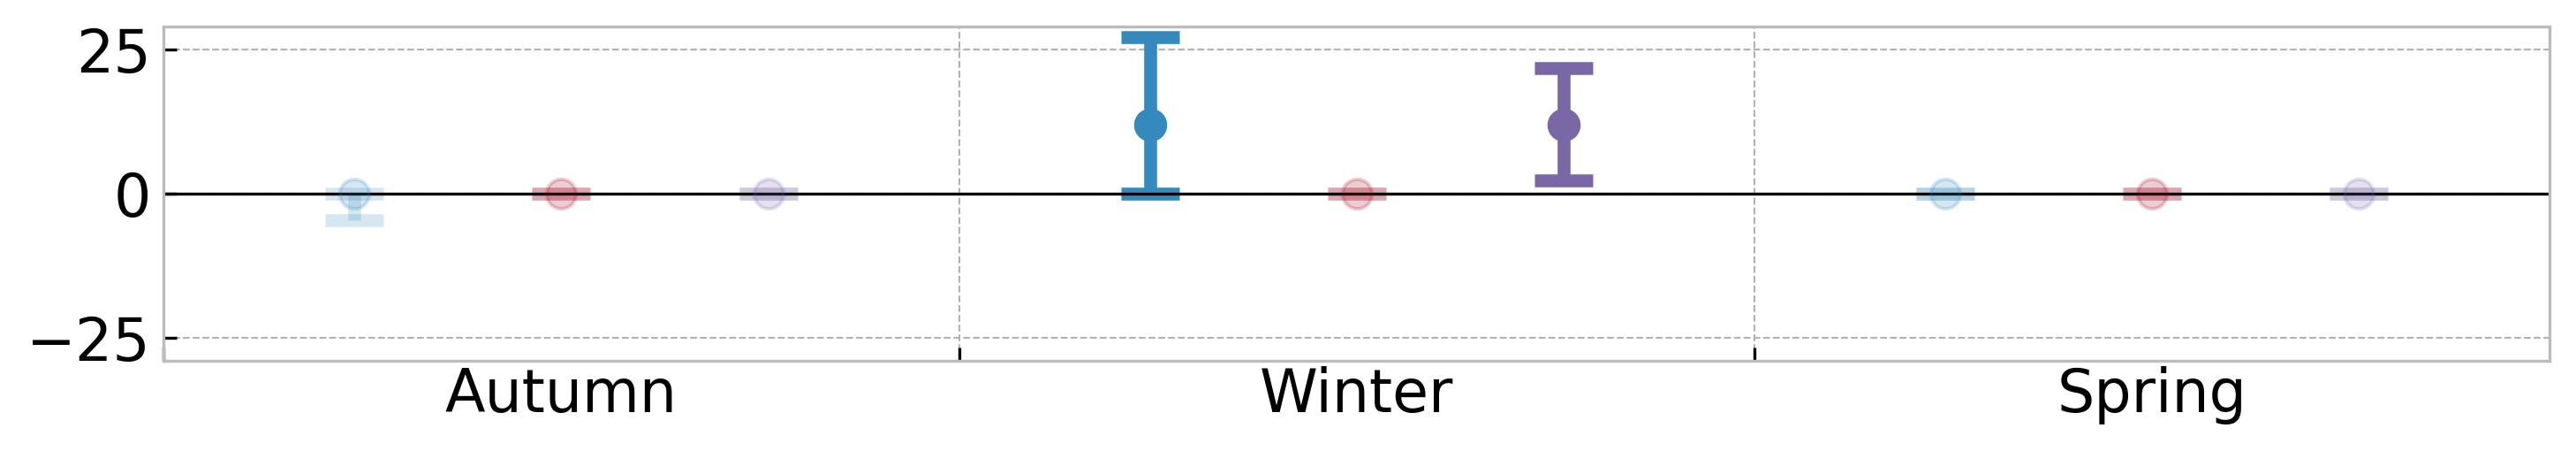

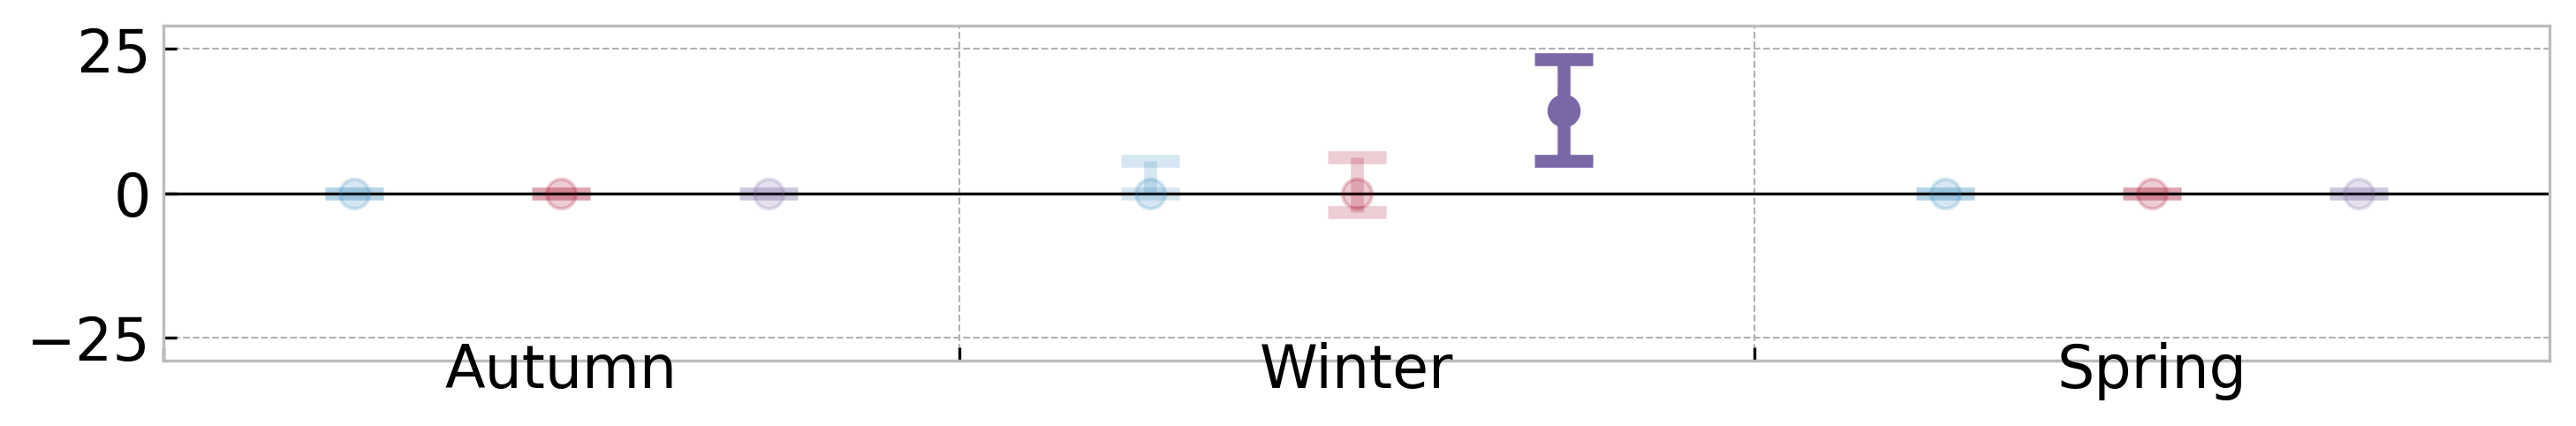

In [12]:
fig, ax = plot_monthly_boxplots(["Autumn", "Winter", "Spring"],
                            [season_slopes_all, season_slopes_merra_best_all, season_slopes_merra0_all],
                            [season_intercepts_all, season_intercepts_merra_best_all, season_intercepts_merra0_all],
                            [p_values_all, p_values_merra_best_all, p_values_merra0_all],
                            [season_low_all, season_low_merra_best_all, season_low_merra0_all], 
                            [season_high_all, season_high_merra_best_all, season_high_merra0_all], 
                            [array_list_all, array_list_merra_best_all, array_list_merra_all],
                            ["CAOnet", r"$M_{3.75}$", r"$M_0$"], alpha=0.05,
                            figsize=[figsize_trends[0],2],
                            legend=False)


# ax.set_ylabel("[%]")
ax.set_yticks([-25, 0, 25])
ax.set_ylim([-28, 28])
fig, ax = plot_monthly_boxplots(["Autumn", "Winter", "Spring"],
                            [season_slopes_south, season_slopes_merra_best_south, season_slopes_merra0_south],
                            [season_intercepts_south, season_intercepts_merra_best_south, season_intercepts_merra0_south],
                            [p_values_south, p_values_merra_best_south, p_values_merra0_south],
                            [season_low_south, season_low_merra_best_south, season_low_merra0_south], 
                            [season_high_south, season_high_merra_best_south, season_high_merra0_south], 
                            [array_list_south, array_list_merra_best_south, array_list_merra_south],
                            ["CAOnet", r"$M_{3.75}$", r"$M_0$"], alpha=0.05,
                            figsize=[figsize_trends[0],2],
                            legend=False)
# ax.set_ylabel("[%]")
ax.set_yticks([-25, 0, 25])
ax.set_ylim([-29, 29])

fig, ax = plot_monthly_boxplots(["Autumn", "Winter", "Spring"],
                            [season_slopes_north, season_slopes_merra_best_north, season_slopes_merra0_north],
                            [season_intercepts_north, season_intercepts_merra_best_north, season_intercepts_merra0_north],
                            [p_values_north, p_values_merra_best_north, p_values_merra0_north],
                            [season_low_north, season_low_merra_best_north, season_low_merra0_north], 
                            [season_high_north, season_high_merra_best_north, season_high_merra0_north], 
                            [array_list_north, array_list_merra_best_north, array_list_merra_north],
                            ["CAOnet", r"$M_{3.75}$", r"$M_0$"], alpha=0.05,
                            figsize=[figsize_trends[0],2],
                            legend=False)
ax.set_yticks([-25, 0, 25])
ax.set_ylim([-29, 29])

In [13]:
T850_ds = xr.open_dataarray(f"{data_folder}/T850_20000301-20250228.nc")
TS_ds = xr.open_dataarray(f"{data_folder}/TS_20000301-20250228.nc")


In [14]:
xr_mask_all = np.where(all_ & (obs_mask.values>=90), 1, 0)
xr_mask_north = np.where(north & (obs_mask.values>=90), 1, 0)
xr_mask_south = np.where(south & (obs_mask.values>=90), 1, 0)

TS_ds_all = TS_ds.where(xr_mask_all).mean(axis=(1,2))
TS_ds_south = TS_ds.where(xr_mask_south).mean(axis=(1,2))
TS_ds_north = TS_ds.where(xr_mask_north).mean(axis=(1,2))

date_range = pd.date_range(start=f"2000-03-01", end=f"2025-02-28")
TS_ds_south_complete = TS_ds_south.reindex(time=date_range)
TS_ds_north_complete = TS_ds_north.reindex(time=date_range)


T850_ds_all = T850_ds.where(xr_mask_all).mean(axis=(1,2))
T850_ds_south = T850_ds.where(xr_mask_south).mean(axis=(1,2))
T850_ds_north = T850_ds.where(xr_mask_north).mean(axis=(1,2))

caonet_ds_all = CAOnet_CAO_mask.where(xr_mask_all).mean(axis=(1,2))
caonet_ds_south = CAOnet_CAO_mask.where(xr_mask_south).mean(axis=(1,2))
caonet_ds_north = CAOnet_CAO_mask.where(xr_mask_north).mean(axis=(1,2))

merra_best_ds_all = CAO_mask_M3_75.where(xr_mask_all).mean(axis=(1,2))
merra_best_ds_south = CAO_mask_M3_75.where(xr_mask_south).mean(axis=(1,2))
merra_best_ds_north = CAO_mask_M3_75.where(xr_mask_north).mean(axis=(1,2))

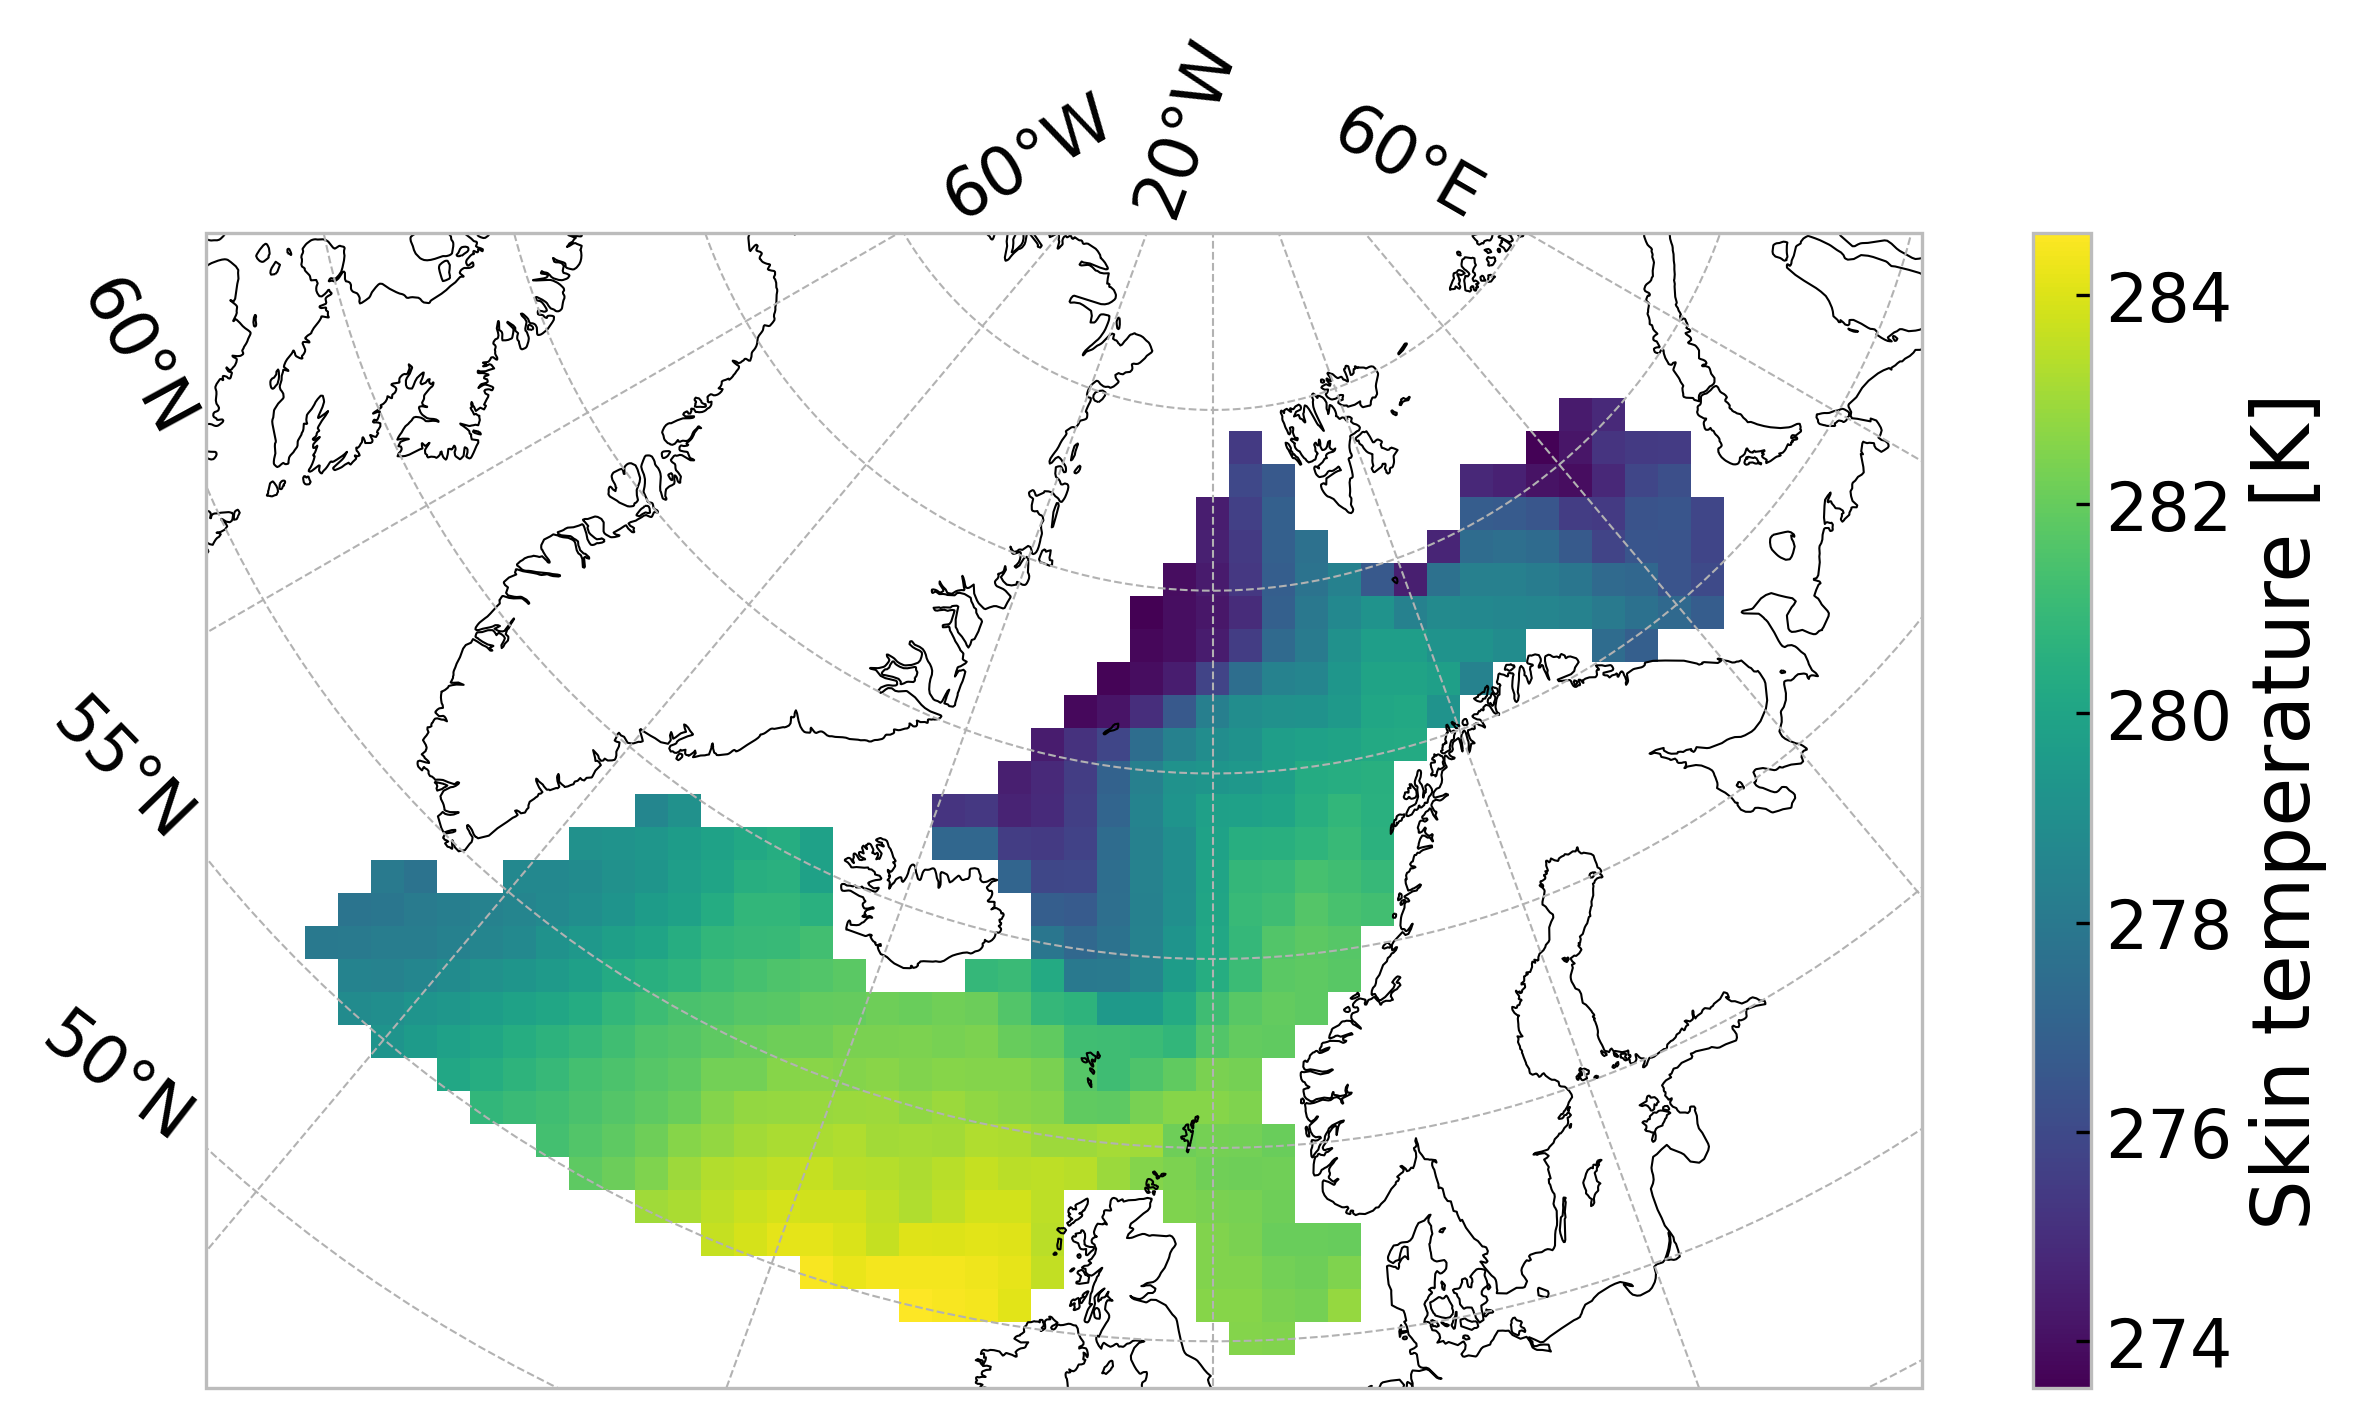

In [15]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=(9.5, 5), dpi=300)
im = ax.pcolormesh(TS_ds.lon, TS_ds.lat, TS_ds.where(xr_mask_all).mean(axis=0), transform=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.right_labels = False
gl.bottom_labels = False
plt.colorbar(im, ax=ax, orientation='vertical', label='Skin temperature [K]')
ax.set_facecolor("white")
plt.show()

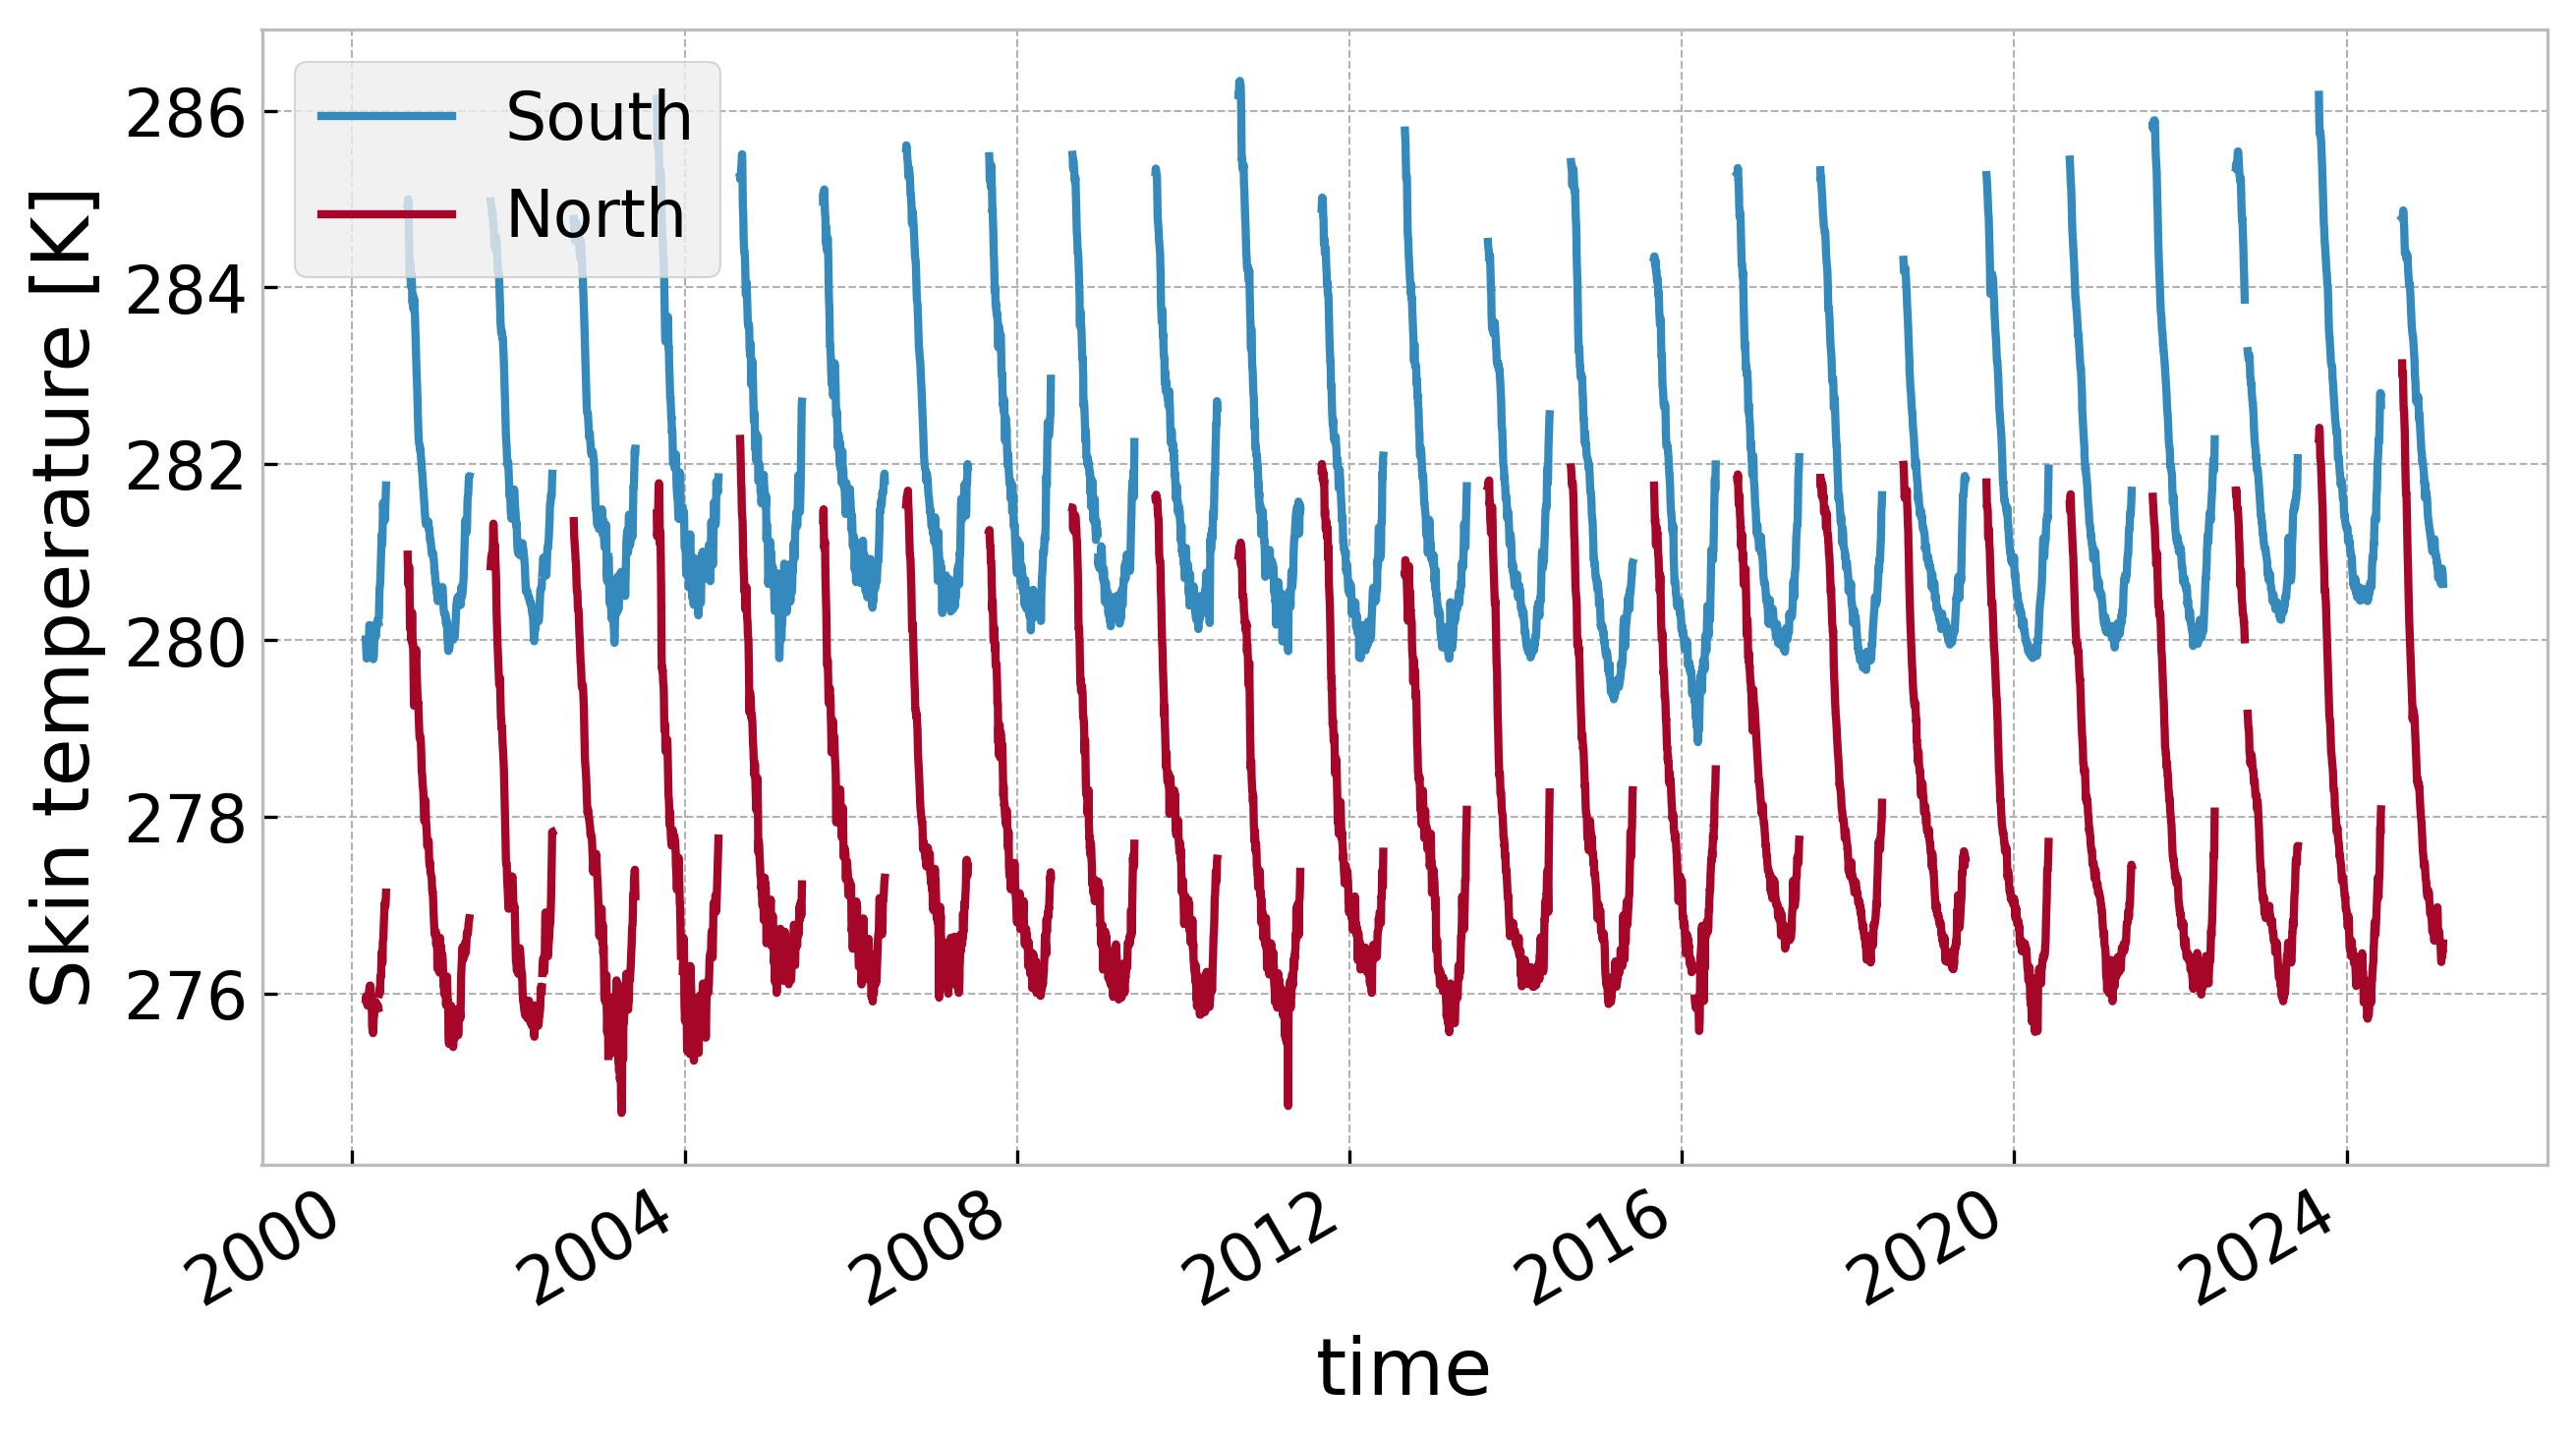

In [16]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
TS_ds_south_complete.plot(label="South")
TS_ds_north_complete.plot(label="North")
ax.set_ylabel("Skin temperature [K]")
ax.set_facecolor("white")
plt.legend()